# Mohs Hardness
[Kaggle Competiton](https://www.kaggle.com/competitions/playground-series-s3e25/)



In [22]:
import pandas as pd
mnist_train = pd.read_csv("/home/rainer/Downloads/ML_datasets/mohs_hardness_train.csv")
mnist_train


,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.000000,4.800000,20.612526,11.088100,2.766000,1.732000,0.860000,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.000000,4.800000,20.298893,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.600000,5.600000,33.739258,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.000000,4.800000,20.213349,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.600000,4.800000,24.988133,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10402,10402,128.0,7.558488,12.000000,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,4.0
10403,10403,30.0,1.743160,10.000000,5.333333,20.766935,14.163933,3.090000,1.556667,0.866667,0.480390,0.81480,5.0
10404,10404,196.0,30.920000,24.500000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1.8
10405,10405,38.0,1.553160,12.666667,4.666667,26.621687,11.290033,2.743333,1.756667,0.980000,0.486507,0.77755,6.0


In [23]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import optuna
from sklearn.metrics import accuracy_score


def convert(dataframe):
    dataframe.set_index("id", inplace=True)
    return dataframe


mnist_train = pd.read_csv("/home/rainer/Downloads/ML_datasets/mohs_hardness_train.csv")
mnist_train = convert(mnist_train)

X, Y = mnist_train.drop('Hardness', axis=1), mnist_train[['Hardness']]
dtrain = xgb.DMatrix(X, Y, enable_categorical=False)

boostrounds=100

def objective(trial):
    param = {
        'tree_method':'gpu_hist',
        "objective": "reg:absoluteerror", #https://xgboost.readthedocs.io/en/stable/parameter.html#learning-task-parameters
        'eta': trial.suggest_float('eta', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.01, 10, log=True),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.1, 1),
    }


    results = xgb.cv(
        params=param,
        dtrain=dtrain,
        num_boost_round=boostrounds,
        nfold=5,
        early_stopping_rounds=50,
        verbose_eval=100, # print eval every xth round
        metrics=["rmse", "mae"], #see "eval_metric"
    )
    
    # print(results)

    return results.iloc[-1]["test-mae-mean"]

In [24]:
study = optuna.create_study(direction='minimize') # watch out! AUC needs to be maximized
study.optimize(objective, n_trials=300)
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-11-14 22:48:12,825] A new study created in memory with name: no-name-df1f60ef-2515-4f40-8e70-9ff15f6d5e87


[0]	train-rmse:1.41857+0.01150	train-mae:0.94749+0.01189	test-rmse:1.50493+0.00751	test-mae:1.03260+0.01220
[49]	train-rmse:3.10882+0.14810	train-mae:2.17117+0.07467	test-rmse:5.09325+0.28481	test-mae:3.67296+0.14346


[I 2023-11-14 22:48:15,233] Trial 0 finished with value: 1.0326004266446032 and parameters: {'eta': 0.2811394017204539, 'max_depth': 9, 'min_child_weight': 0.06991609752026173, 'subsample': 0.2971922618831738, 'colsample_bynode': 0.46138792780547233}. Best is trial 0 with value: 1.0326004266446032.


[0]	train-rmse:1.43031+0.00873	train-mae:0.98737+0.00520	test-rmse:1.45804+0.03326	test-mae:1.00948+0.01300
[64]	train-rmse:1.18318+0.00538	train-mae:0.78992+0.00232	test-rmse:1.38506+0.02621	test-mae:0.98553+0.01235


[I 2023-11-14 22:48:16,013] Trial 1 finished with value: 0.9620869231904674 and parameters: {'eta': 0.4539438986926465, 'max_depth': 4, 'min_child_weight': 1.5545617657106072, 'subsample': 0.7425791658714199, 'colsample_bynode': 0.665938968698238}. Best is trial 1 with value: 0.9620869231904674.


[0]	train-rmse:1.30354+0.00906	train-mae:0.84643+0.00804	test-rmse:1.48646+0.02412	test-mae:1.00673+0.01993
[49]	train-rmse:0.75683+0.02500	train-mae:0.44393+0.01405	test-rmse:2.11958+0.04757	test-mae:1.55680+0.03331


[I 2023-11-14 22:48:20,103] Trial 2 finished with value: 1.0067272238782934 and parameters: {'eta': 0.263880387593387, 'max_depth': 10, 'min_child_weight': 0.48526223676955565, 'subsample': 0.563893475584766, 'colsample_bynode': 0.8142044520553702}. Best is trial 1 with value: 0.9620869231904674.


[0]	train-rmse:1.32433+0.01038	train-mae:0.89024+0.00661	test-rmse:1.41057+0.01914	test-mae:0.96866+0.01324
[50]	train-rmse:0.98902+0.01555	train-mae:0.62411+0.00888	test-rmse:1.62903+0.03117	test-mae:1.18499+0.02524


[I 2023-11-14 22:48:21,539] Trial 3 finished with value: 0.9686615215944905 and parameters: {'eta': 0.19105617221472124, 'max_depth': 7, 'min_child_weight': 1.8243898031293209, 'subsample': 0.6434121012857074, 'colsample_bynode': 0.9127335674544627}. Best is trial 1 with value: 0.9620869231904674.


[0]	train-rmse:1.40424+0.01044	train-mae:0.95961+0.00807	test-rmse:1.45544+0.01111	test-mae:1.00420+0.01330
[49]	train-rmse:1.63321+0.02920	train-mae:1.17177+0.01868	test-rmse:2.27143+0.06135	test-mae:1.67814+0.03879


[I 2023-11-14 22:48:22,578] Trial 4 finished with value: 1.0041974425248446 and parameters: {'eta': 0.4230558132378898, 'max_depth': 6, 'min_child_weight': 0.7949620271270357, 'subsample': 0.3055308382534243, 'colsample_bynode': 0.8753548335039355}. Best is trial 1 with value: 0.9620869231904674.


[0]	train-rmse:1.34812+0.01925	train-mae:0.89099+0.01437	test-rmse:1.48943+0.01684	test-mae:1.01841+0.01318
[49]	train-rmse:1.06720+0.02753	train-mae:0.70314+0.01814	test-rmse:2.35169+0.05308	test-mae:1.74020+0.04288


[I 2023-11-14 22:48:24,953] Trial 5 finished with value: 1.0184071295848276 and parameters: {'eta': 0.41838455317717027, 'max_depth': 9, 'min_child_weight': 0.2570444193487425, 'subsample': 0.476769417168469, 'colsample_bynode': 0.5735191363807887}. Best is trial 1 with value: 0.9620869231904674.


[0]	train-rmse:1.46014+0.01761	train-mae:1.00527+0.00354	test-rmse:1.48921+0.04229	test-mae:1.02979+0.02469
[51]	train-rmse:1.42614+0.01936	train-mae:1.02631+0.01381	test-rmse:1.62828+0.04414	test-mae:1.21246+0.03662


[I 2023-11-14 22:48:25,648] Trial 6 finished with value: 1.0162092075169966 and parameters: {'eta': 0.15230926817076906, 'max_depth': 4, 'min_child_weight': 0.06481280790622732, 'subsample': 0.27030586230606224, 'colsample_bynode': 0.8423006369045691}. Best is trial 1 with value: 0.9620869231904674.


[0]	train-rmse:1.49890+0.00726	train-mae:1.04497+0.00486	test-rmse:1.49621+0.02231	test-mae:1.04043+0.01619
[53]	train-rmse:1.49595+0.01892	train-mae:1.09550+0.01406	test-rmse:1.62315+0.01884	test-mae:1.20116+0.02085


[I 2023-11-14 22:48:26,267] Trial 7 finished with value: 1.0222679787414986 and parameters: {'eta': 0.22522005784424615, 'max_depth': 3, 'min_child_weight': 0.08217935967314796, 'subsample': 0.1640901747058408, 'colsample_bynode': 0.8410024577399071}. Best is trial 1 with value: 0.9620869231904674.


[0]	train-rmse:1.46237+0.02204	train-mae:1.02111+0.00355	test-rmse:1.48156+0.04404	test-mae:1.03644+0.01677
[99]	train-rmse:1.20161+0.01012	train-mae:0.80828+0.00699	test-rmse:1.34456+0.02516	test-mae:0.95102+0.01226


[I 2023-11-14 22:48:27,305] Trial 8 finished with value: 0.9510157791823808 and parameters: {'eta': 0.14345118393750944, 'max_depth': 3, 'min_child_weight': 4.284433212612989, 'subsample': 0.9450861367150117, 'colsample_bynode': 0.795840561596012}. Best is trial 8 with value: 0.9510157791823808.


[0]	train-rmse:1.45491+0.00854	train-mae:1.03669+0.00546	test-rmse:1.46389+0.02091	test-mae:1.04524+0.01255
[76]	train-rmse:1.22927+0.00387	train-mae:0.85604+0.00234	test-rmse:1.34832+0.01974	test-mae:0.97183+0.00710


[I 2023-11-14 22:48:28,119] Trial 9 finished with value: 0.9605012647194805 and parameters: {'eta': 0.4482157750129032, 'max_depth': 3, 'min_child_weight': 0.011576199724028192, 'subsample': 0.5248903645128897, 'colsample_bynode': 0.3715434671837565}. Best is trial 8 with value: 0.9510157791823808.


[0]	train-rmse:1.40017+0.01026	train-mae:0.94417+0.00526	test-rmse:1.44173+0.01781	test-mae:0.97816+0.01632
[52]	train-rmse:1.10779+0.02025	train-mae:0.70943+0.01686	test-rmse:1.41505+0.02553	test-mae:1.00432+0.02565


[I 2023-11-14 22:48:29,138] Trial 10 finished with value: 0.9671717391008074 and parameters: {'eta': 0.06387247939610592, 'max_depth': 6, 'min_child_weight': 9.709701320785982, 'subsample': 0.8890693796298632, 'colsample_bynode': 0.26743264147822593}. Best is trial 8 with value: 0.9510157791823808.


[0]	train-rmse:1.56290+0.01926	train-mae:1.10843+0.00443	test-rmse:1.56892+0.03488	test-mae:1.11738+0.01386
[99]	train-rmse:1.24411+0.00666	train-mae:0.85254+0.00455	test-rmse:1.36681+0.00886	test-mae:0.97072+0.00703


[I 2023-11-14 22:48:30,172] Trial 11 finished with value: 0.970715275295863 and parameters: {'eta': 0.34416660582066616, 'max_depth': 3, 'min_child_weight': 0.011110636684213741, 'subsample': 0.9654785983715298, 'colsample_bynode': 0.1131395477999424}. Best is trial 8 with value: 0.9510157791823808.


[0]	train-rmse:1.39916+0.00314	train-mae:0.96300+0.00637	test-rmse:1.43020+0.02487	test-mae:0.98999+0.01066
[51]	train-rmse:1.14124+0.01529	train-mae:0.74626+0.00917	test-rmse:1.42727+0.03157	test-mae:1.01556+0.02418


[I 2023-11-14 22:48:31,004] Trial 12 finished with value: 0.9767154415281164 and parameters: {'eta': 0.49794560115224734, 'max_depth': 5, 'min_child_weight': 0.017937360487183654, 'subsample': 0.7956063882097704, 'colsample_bynode': 0.4147351283271377}. Best is trial 8 with value: 0.9510157791823808.


[0]	train-rmse:1.47540+0.01815	train-mae:1.02529+0.00897	test-rmse:1.49061+0.04265	test-mae:1.03622+0.01628
[99]	train-rmse:1.20519+0.01579	train-mae:0.81186+0.00606	test-rmse:1.34516+0.03170	test-mae:0.94964+0.01667


[I 2023-11-14 22:48:32,048] Trial 13 finished with value: 0.9496366718026146 and parameters: {'eta': 0.11749439741451102, 'max_depth': 3, 'min_child_weight': 6.321389866720578, 'subsample': 0.9594831078419379, 'colsample_bynode': 0.6656887354298866}. Best is trial 13 with value: 0.9496366718026146.


[0]	train-rmse:1.36622+0.00985	train-mae:0.93542+0.00979	test-rmse:1.40885+0.01960	test-mae:0.97411+0.01598
[51]	train-rmse:1.12603+0.01916	train-mae:0.72733+0.01158	test-rmse:1.38763+0.03125	test-mae:0.98054+0.02368


[I 2023-11-14 22:48:32,884] Trial 14 finished with value: 0.9540845916277924 and parameters: {'eta': 0.013211884456197615, 'max_depth': 5, 'min_child_weight': 9.814581087246223, 'subsample': 0.9848877743146383, 'colsample_bynode': 0.7057508759174419}. Best is trial 13 with value: 0.9496366718026146.


[0]	train-rmse:1.42591+0.01113	train-mae:0.98471+0.00667	test-rmse:1.45070+0.01987	test-mae:1.00963+0.01421
[76]	train-rmse:1.15498+0.00434	train-mae:0.76253+0.00185	test-rmse:1.35611+0.01182	test-mae:0.96866+0.00394


[I 2023-11-14 22:48:33,865] Trial 15 finished with value: 0.9594738339565488 and parameters: {'eta': 0.12204067323848693, 'max_depth': 4, 'min_child_weight': 4.182738563082409, 'subsample': 0.8367606997210865, 'colsample_bynode': 0.9822436140244287}. Best is trial 13 with value: 0.9496366718026146.


[0]	train-rmse:1.30884+0.01031	train-mae:0.87408+0.00708	test-rmse:1.39382+0.02956	test-mae:0.94661+0.02091
[50]	train-rmse:0.96125+0.01342	train-mae:0.56501+0.00948	test-rmse:1.44307+0.03592	test-mae:1.02592+0.02591


[I 2023-11-14 22:48:35,172] Trial 16 finished with value: 0.9420518418082005 and parameters: {'eta': 0.1112164698579973, 'max_depth': 7, 'min_child_weight': 3.552196595102459, 'subsample': 0.9869457070888067, 'colsample_bynode': 0.7151478593671623}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.30544+0.01067	train-mae:0.87547+0.00972	test-rmse:1.39407+0.02567	test-mae:0.95233+0.01231
[50]	train-rmse:0.95904+0.01808	train-mae:0.56180+0.01374	test-rmse:1.45123+0.03340	test-mae:1.03125+0.02100


[I 2023-11-14 22:48:36,476] Trial 17 finished with value: 0.947051890095411 and parameters: {'eta': 0.07134886064449092, 'max_depth': 7, 'min_child_weight': 3.0325940723764457, 'subsample': 0.9989546878791922, 'colsample_bynode': 0.6499650624326051}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.30457+0.01113	train-mae:0.86234+0.00922	test-rmse:1.44721+0.02089	test-mae:0.98712+0.01778
[50]	train-rmse:0.88107+0.01133	train-mae:0.49832+0.00916	test-rmse:1.57162+0.02152	test-mae:1.12682+0.01181


[I 2023-11-14 22:48:38,185] Trial 18 finished with value: 0.9871176882964988 and parameters: {'eta': 0.06346257985255405, 'max_depth': 8, 'min_child_weight': 2.1457009839806522, 'subsample': 0.8563344331134901, 'colsample_bynode': 0.5792283071721032}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.33359+0.01650	train-mae:0.90103+0.00970	test-rmse:1.41415+0.01832	test-mae:0.96955+0.01168
[49]	train-rmse:1.00474+0.01483	train-mae:0.62302+0.01057	test-rmse:1.53736+0.02662	test-mae:1.11029+0.02006


[I 2023-11-14 22:48:39,456] Trial 19 finished with value: 0.9695538060046779 and parameters: {'eta': 0.010635218403510616, 'max_depth': 7, 'min_child_weight': 3.4260295877750333, 'subsample': 0.7656865744210628, 'colsample_bynode': 0.5242252680987668}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.30890+0.01629	train-mae:0.87037+0.01236	test-rmse:1.44063+0.01979	test-mae:0.98154+0.01160
[49]	train-rmse:0.87520+0.01564	train-mae:0.52417+0.01082	test-rmse:1.67558+0.02398	test-mae:1.22030+0.01284


[I 2023-11-14 22:48:42,167] Trial 20 finished with value: 0.981537198365173 and parameters: {'eta': 0.08441489255940415, 'max_depth': 8, 'min_child_weight': 1.4518184353867536, 'subsample': 0.6967394733001673, 'colsample_bynode': 0.7323534316115129}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.31081+0.01384	train-mae:0.87617+0.00843	test-rmse:1.39492+0.02640	test-mae:0.94978+0.01493
[50]	train-rmse:0.97457+0.01311	train-mae:0.57744+0.00945	test-rmse:1.46355+0.01724	test-mae:1.04016+0.01464


[I 2023-11-14 22:48:43,882] Trial 21 finished with value: 0.9497780166732355 and parameters: {'eta': 0.09996115684445672, 'max_depth': 7, 'min_child_weight': 6.024897753588284, 'subsample': 0.9982929767246904, 'colsample_bynode': 0.6483526625400079}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.28943+0.00702	train-mae:0.85028+0.00515	test-rmse:1.42350+0.03326	test-mae:0.96407+0.02100
[49]	train-rmse:0.87107+0.01372	train-mae:0.48656+0.01115	test-rmse:1.53266+0.03268	test-mae:1.09623+0.02047


[I 2023-11-14 22:48:45,635] Trial 22 finished with value: 0.9640714394325146 and parameters: {'eta': 0.17251925075985944, 'max_depth': 8, 'min_child_weight': 2.9525107356606863, 'subsample': 0.8962250047691185, 'colsample_bynode': 0.725478275537246}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.36420+0.00687	train-mae:0.92054+0.00885	test-rmse:1.42541+0.01908	test-mae:0.97338+0.00876
[52]	train-rmse:1.06123+0.01125	train-mae:0.66118+0.00704	test-rmse:1.44327+0.02693	test-mae:1.02682+0.01444


[I 2023-11-14 22:48:46,681] Trial 23 finished with value: 0.9631644795708805 and parameters: {'eta': 0.10787781109857009, 'max_depth': 6, 'min_child_weight': 6.31608199699659, 'subsample': 0.9144852656439499, 'colsample_bynode': 0.6267024951124839}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.38426+0.01296	train-mae:0.94795+0.00888	test-rmse:1.42956+0.00995	test-mae:0.98413+0.00926
[53]	train-rmse:1.11351+0.00331	train-mae:0.71933+0.00374	test-rmse:1.41029+0.02046	test-mae:0.99938+0.01842


[I 2023-11-14 22:48:47,646] Trial 24 finished with value: 0.9670008254966518 and parameters: {'eta': 0.05618825618011464, 'max_depth': 5, 'min_child_weight': 1.0124011647928797, 'subsample': 0.871973551411307, 'colsample_bynode': 0.7660100815127776}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.32078+0.01347	train-mae:0.88622+0.00907	test-rmse:1.41141+0.02105	test-mae:0.96600+0.01397
[50]	train-rmse:0.97227+0.01200	train-mae:0.58473+0.00506	test-rmse:1.51915+0.02198	test-mae:1.09431+0.01342


[I 2023-11-14 22:48:49,031] Trial 25 finished with value: 0.9660037236363668 and parameters: {'eta': 0.13532801977520495, 'max_depth': 7, 'min_child_weight': 2.931241693042032, 'subsample': 0.8151266216871145, 'colsample_bynode': 0.6732335421682182}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.25060+0.01030	train-mae:0.81719+0.01135	test-rmse:1.41562+0.02776	test-mae:0.95901+0.01543
[50]	train-rmse:0.81561+0.00999	train-mae:0.43458+0.00723	test-rmse:1.50516+0.03830	test-mae:1.07710+0.01934


[I 2023-11-14 22:48:51,184] Trial 26 finished with value: 0.9590103526950179 and parameters: {'eta': 0.19722848251004887, 'max_depth': 9, 'min_child_weight': 5.39659461401506, 'subsample': 0.9930454422534205, 'colsample_bynode': 0.6021481346056069}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.31379+0.00860	train-mae:0.87200+0.00478	test-rmse:1.40906+0.03099	test-mae:0.95925+0.02402
[50]	train-rmse:0.93554+0.01594	train-mae:0.54910+0.00769	test-rmse:1.46743+0.03132	test-mae:1.05841+0.02742


[I 2023-11-14 22:48:52,737] Trial 27 finished with value: 0.9581514958737453 and parameters: {'eta': 0.09901943485555305, 'max_depth': 8, 'min_child_weight': 9.693496113877409, 'subsample': 0.9018210824522744, 'colsample_bynode': 0.5196681754947627}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.34192+0.00726	train-mae:0.91024+0.00889	test-rmse:1.41328+0.02783	test-mae:0.97061+0.01506
[51]	train-rmse:1.02617+0.00975	train-mae:0.63138+0.00544	test-rmse:1.42542+0.01828	test-mae:1.01688+0.01242


[I 2023-11-14 22:48:53,828] Trial 28 finished with value: 0.9572451508814919 and parameters: {'eta': 0.153641621805203, 'max_depth': 6, 'min_child_weight': 2.333282789954758, 'subsample': 0.9433177848119275, 'colsample_bynode': 0.7627790237929356}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.38797+0.00744	train-mae:0.95235+0.00482	test-rmse:1.42729+0.01991	test-mae:0.98283+0.00940
[59]	train-rmse:1.10529+0.00990	train-mae:0.71597+0.00811	test-rmse:1.41788+0.02911	test-mae:1.00553+0.01263


[I 2023-11-14 22:48:54,797] Trial 29 finished with value: 0.9648797302083096 and parameters: {'eta': 0.2387352846075058, 'max_depth': 5, 'min_child_weight': 3.9695435111556585, 'subsample': 0.8226833748423444, 'colsample_bynode': 0.7019949589282439}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.31565+0.01475	train-mae:0.88233+0.00884	test-rmse:1.42127+0.02395	test-mae:0.97333+0.01492
[50]	train-rmse:0.95800+0.01940	train-mae:0.56462+0.01453	test-rmse:1.49395+0.01973	test-mae:1.06394+0.01396


[I 2023-11-14 22:48:56,135] Trial 30 finished with value: 0.9672210394686127 and parameters: {'eta': 0.04748890235120218, 'max_depth': 7, 'min_child_weight': 1.2450641262027284, 'subsample': 0.9220275381244859, 'colsample_bynode': 0.6206374762902837}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.30879+0.00921	train-mae:0.87515+0.00741	test-rmse:1.39644+0.02607	test-mae:0.95171+0.01577
[50]	train-rmse:0.98317+0.00993	train-mae:0.58275+0.00521	test-rmse:1.44299+0.01297	test-mae:1.02289+0.01346


[I 2023-11-14 22:48:57,399] Trial 31 finished with value: 0.9462588202623714 and parameters: {'eta': 0.10231889566045824, 'max_depth': 7, 'min_child_weight': 6.75596654449016, 'subsample': 0.9772372722312037, 'colsample_bynode': 0.6495516657919381}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.28440+0.01652	train-mae:0.84821+0.00740	test-rmse:1.40040+0.03287	test-mae:0.94705+0.02576
[50]	train-rmse:0.89596+0.01029	train-mae:0.50440+0.00533	test-rmse:1.45483+0.03626	test-mae:1.03426+0.02393


[I 2023-11-14 22:48:58,968] Trial 32 finished with value: 0.9449735457249686 and parameters: {'eta': 0.12130459901118978, 'max_depth': 8, 'min_child_weight': 6.058582055439728, 'subsample': 0.9867418388755755, 'colsample_bynode': 0.6640500765074517}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.23571+0.01387	train-mae:0.80045+0.01424	test-rmse:1.43586+0.01866	test-mae:0.97452+0.00948
[49]	train-rmse:0.71674+0.01629	train-mae:0.36034+0.01400	test-rmse:1.63461+0.02795	test-mae:1.18345+0.02429


[I 2023-11-14 22:49:01,813] Trial 33 finished with value: 0.9745223636388365 and parameters: {'eta': 0.08380143928561029, 'max_depth': 10, 'min_child_weight': 2.414303138952932, 'subsample': 0.8611996701165343, 'colsample_bynode': 0.5273068748173109}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.30842+0.01486	train-mae:0.87008+0.01277	test-rmse:1.43919+0.01242	test-mae:0.97321+0.00907
[50]	train-rmse:0.87572+0.01411	train-mae:0.51406+0.00844	test-rmse:1.68716+0.01463	test-mae:1.22766+0.01111


[I 2023-11-14 22:49:03,611] Trial 34 finished with value: 0.9732055974612374 and parameters: {'eta': 0.17221572713789599, 'max_depth': 8, 'min_child_weight': 1.9412888760911846, 'subsample': 0.7242516751816539, 'colsample_bynode': 0.7653864874869388}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.25324+0.01817	train-mae:0.82230+0.01075	test-rmse:1.41180+0.03442	test-mae:0.95510+0.02259
[50]	train-rmse:0.82148+0.02726	train-mae:0.43972+0.01789	test-rmse:1.49577+0.04586	test-mae:1.06848+0.03365


[I 2023-11-14 22:49:05,554] Trial 35 finished with value: 0.9551043603087646 and parameters: {'eta': 0.03502256543309197, 'max_depth': 9, 'min_child_weight': 6.736195420679581, 'subsample': 0.993843542118807, 'colsample_bynode': 0.666859816419296}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.32433+0.01291	train-mae:0.89330+0.01488	test-rmse:1.42496+0.02614	test-mae:0.97731+0.01366
[50]	train-rmse:0.96369+0.00758	train-mae:0.57683+0.00844	test-rmse:1.55984+0.03399	test-mae:1.11385+0.02961


[I 2023-11-14 22:49:06,914] Trial 36 finished with value: 0.9773087493880006 and parameters: {'eta': 0.08146477338913304, 'max_depth': 7, 'min_child_weight': 0.7568494814600837, 'subsample': 0.7700167172352649, 'colsample_bynode': 0.5771084489147648}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.27439+0.01162	train-mae:0.84027+0.00622	test-rmse:1.42471+0.02697	test-mae:0.96293+0.01575
[51]	train-rmse:0.84533+0.01166	train-mae:0.46430+0.01034	test-rmse:1.52888+0.02533	test-mae:1.09054+0.02244


[I 2023-11-14 22:49:08,734] Trial 37 finished with value: 0.9602096473834774 and parameters: {'eta': 0.1254529671433591, 'max_depth': 8, 'min_child_weight': 1.6571936601421786, 'subsample': 0.9400873309641089, 'colsample_bynode': 0.7969862441945639}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.36737+0.01315	train-mae:0.92657+0.00731	test-rmse:1.43205+0.01610	test-mae:0.98361+0.01205
[53]	train-rmse:1.05201+0.01017	train-mae:0.65721+0.00624	test-rmse:1.45207+0.02220	test-mae:1.03470+0.01496


[I 2023-11-14 22:49:09,797] Trial 38 finished with value: 0.9702351362392149 and parameters: {'eta': 0.0429857488248875, 'max_depth': 6, 'min_child_weight': 3.5947000560822664, 'subsample': 0.8527703408619147, 'colsample_bynode': 0.6238155371812579}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.23272+0.01523	train-mae:0.80289+0.01190	test-rmse:1.42638+0.02747	test-mae:0.96389+0.02359
[49]	train-rmse:0.76130+0.02902	train-mae:0.38405+0.01822	test-rmse:1.58381+0.02406	test-mae:1.12564+0.02300


[I 2023-11-14 22:49:12,235] Trial 39 finished with value: 0.9638856885293556 and parameters: {'eta': 0.18611111755356669, 'max_depth': 9, 'min_child_weight': 0.5493199309665406, 'subsample': 0.9256985725136256, 'colsample_bynode': 0.7064968425777219}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.35984+0.01229	train-mae:0.91251+0.00940	test-rmse:1.43644+0.03058	test-mae:0.98251+0.01189
[50]	train-rmse:1.06096+0.01195	train-mae:0.68515+0.00892	test-rmse:1.60178+0.01428	test-mae:1.16900+0.00966


[I 2023-11-14 22:49:13,517] Trial 40 finished with value: 0.9794740338291088 and parameters: {'eta': 0.14662729747200598, 'max_depth': 7, 'min_child_weight': 4.761390302437529, 'subsample': 0.6113881177522512, 'colsample_bynode': 0.48540166599246426}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.33881+0.00731	train-mae:0.90709+0.00930	test-rmse:1.40055+0.02702	test-mae:0.96227+0.01495
[52]	train-rmse:1.03683+0.00525	train-mae:0.64001+0.00240	test-rmse:1.42362+0.03902	test-mae:1.01366+0.02677


[I 2023-11-14 22:49:14,549] Trial 41 finished with value: 0.9493741555988203 and parameters: {'eta': 0.11381729863095257, 'max_depth': 6, 'min_child_weight': 6.937224837162915, 'subsample': 0.9560401968848046, 'colsample_bynode': 0.6613992876814225}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.35078+0.00589	train-mae:0.91807+0.00743	test-rmse:1.41175+0.01734	test-mae:0.97262+0.00591
[52]	train-rmse:1.04776+0.01267	train-mae:0.64842+0.00981	test-rmse:1.42645+0.03082	test-mae:1.01320+0.02175


[I 2023-11-14 22:49:15,579] Trial 42 finished with value: 0.9539354682789714 and parameters: {'eta': 0.08040049202499128, 'max_depth': 6, 'min_child_weight': 7.557954588893681, 'subsample': 0.9564801971301793, 'colsample_bynode': 0.5895265684783124}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.35085+0.01006	train-mae:0.91465+0.00632	test-rmse:1.41473+0.02026	test-mae:0.97008+0.00673
[52]	train-rmse:1.04712+0.01421	train-mae:0.64986+0.01068	test-rmse:1.44233+0.02342	test-mae:1.02859+0.01720


[I 2023-11-14 22:49:16,612] Trial 43 finished with value: 0.956795400374317 and parameters: {'eta': 0.11045580939141147, 'max_depth': 6, 'min_child_weight': 4.886504268705831, 'subsample': 0.8988519875953643, 'colsample_bynode': 0.657664278049842}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.30913+0.00609	train-mae:0.87256+0.00792	test-rmse:1.40955+0.02702	test-mae:0.95633+0.01315
[51]	train-rmse:0.95099+0.01231	train-mae:0.55311+0.00978	test-rmse:1.46099+0.02501	test-mae:1.03628+0.01403


[I 2023-11-14 22:49:17,929] Trial 44 finished with value: 0.9546416285686206 and parameters: {'eta': 0.20738398329173752, 'max_depth': 7, 'min_child_weight': 3.362000388394421, 'subsample': 0.9918784114084004, 'colsample_bynode': 0.8262194504191156}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.29373+0.01748	train-mae:0.85622+0.01456	test-rmse:1.40620+0.01792	test-mae:0.95613+0.01006
[50]	train-rmse:0.90113+0.01964	train-mae:0.51438+0.01562	test-rmse:1.45842+0.02305	test-mae:1.04424+0.02083


[I 2023-11-14 22:49:19,487] Trial 45 finished with value: 0.9495140643690789 and parameters: {'eta': 0.14178079368822427, 'max_depth': 8, 'min_child_weight': 7.715607229046157, 'subsample': 0.9523224790891675, 'colsample_bynode': 0.5618796129607555}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.32003+0.01183	train-mae:0.88457+0.00830	test-rmse:1.40989+0.02455	test-mae:0.96120+0.01389
[51]	train-rmse:0.96689+0.01281	train-mae:0.57273+0.00814	test-rmse:1.47071+0.01548	test-mae:1.05013+0.01087


[I 2023-11-14 22:49:20,809] Trial 46 finished with value: 0.9607142591109664 and parameters: {'eta': 0.15623798080699575, 'max_depth': 7, 'min_child_weight': 4.849195782817179, 'subsample': 0.8909922281871225, 'colsample_bynode': 0.8628186945997649}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.36184+0.01427	train-mae:0.92002+0.00558	test-rmse:1.42323+0.01904	test-mae:0.97183+0.01273
[51]	train-rmse:1.04314+0.00550	train-mae:0.65051+0.00492	test-rmse:1.48460+0.01808	test-mae:1.06106+0.01403


[I 2023-11-14 22:49:21,863] Trial 47 finished with value: 0.9593669037326918 and parameters: {'eta': 0.1232340483713008, 'max_depth': 6, 'min_child_weight': 2.7509245784995215, 'subsample': 0.804347784254092, 'colsample_bynode': 0.6897576030135404}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.30970+0.00935	train-mae:0.87747+0.00765	test-rmse:1.39960+0.02800	test-mae:0.95423+0.02625
[51]	train-rmse:0.96833+0.01508	train-mae:0.57461+0.01307	test-rmse:1.44549+0.03363	test-mae:1.03155+0.02452


[I 2023-11-14 22:49:23,159] Trial 48 finished with value: 0.9526479490562032 and parameters: {'eta': 0.029260800699637657, 'max_depth': 7, 'min_child_weight': 7.865558934548143, 'subsample': 0.9595670351591349, 'colsample_bynode': 0.7453311007944948}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.38551+0.01451	train-mae:0.95088+0.00864	test-rmse:1.43751+0.01635	test-mae:0.99452+0.01144
[55]	train-rmse:1.10210+0.01000	train-mae:0.71140+0.00825	test-rmse:1.42344+0.02232	test-mae:1.01630+0.01526


[I 2023-11-14 22:49:24,073] Trial 49 finished with value: 0.9723595220632019 and parameters: {'eta': 0.2740367696950368, 'max_depth': 5, 'min_child_weight': 1.94240933960598, 'subsample': 0.8617840378833556, 'colsample_bynode': 0.7923001493611438}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.22935+0.01364	train-mae:0.79962+0.00811	test-rmse:1.43508+0.03921	test-mae:0.97098+0.02300
[49]	train-rmse:0.73259+0.00880	train-mae:0.36764+0.00810	test-rmse:1.55665+0.03249	test-mae:1.11290+0.01474


[I 2023-11-14 22:49:26,711] Trial 50 finished with value: 0.9709762090861244 and parameters: {'eta': 0.0961381798674046, 'max_depth': 10, 'min_child_weight': 3.9580153951649897, 'subsample': 0.9433247648284948, 'colsample_bynode': 0.6363554322200978}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.30140+0.00880	train-mae:0.86043+0.00659	test-rmse:1.41947+0.01131	test-mae:0.96305+0.00630
[51]	train-rmse:0.92199+0.01182	train-mae:0.53332+0.00692	test-rmse:1.47103+0.01788	test-mae:1.05397+0.01132


[I 2023-11-14 22:49:28,214] Trial 51 finished with value: 0.9589835013030772 and parameters: {'eta': 0.060562743429411994, 'max_depth': 8, 'min_child_weight': 8.061607907709874, 'subsample': 0.9662257449223361, 'colsample_bynode': 0.5508303585935937}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.29897+0.02157	train-mae:0.85720+0.01313	test-rmse:1.42552+0.02315	test-mae:0.96624+0.01210
[50]	train-rmse:0.89135+0.02062	train-mae:0.50819+0.01012	test-rmse:1.51638+0.03400	test-mae:1.08855+0.01961


[I 2023-11-14 22:49:29,812] Trial 52 finished with value: 0.9662438486525072 and parameters: {'eta': 0.13234133615259885, 'max_depth': 8, 'min_child_weight': 5.930453932152691, 'subsample': 0.9237717648942814, 'colsample_bynode': 0.606680347678088}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.27051+0.01379	train-mae:0.84033+0.01005	test-rmse:1.40222+0.03644	test-mae:0.95417+0.02757
[50]	train-rmse:0.84973+0.01034	train-mae:0.46667+0.00731	test-rmse:1.47682+0.03949	test-mae:1.06292+0.02938


[I 2023-11-14 22:49:31,663] Trial 53 finished with value: 0.9541709537472638 and parameters: {'eta': 0.07197017851962392, 'max_depth': 9, 'min_child_weight': 9.218749353608333, 'subsample': 0.9710640679950776, 'colsample_bynode': 0.7021589448596522}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.28427+0.00933	train-mae:0.84687+0.00907	test-rmse:1.40513+0.03211	test-mae:0.94814+0.02001
[50]	train-rmse:0.89155+0.02075	train-mae:0.50120+0.01416	test-rmse:1.47107+0.02162	test-mae:1.04656+0.01433


[I 2023-11-14 22:49:33,237] Trial 54 finished with value: 0.9481365336716573 and parameters: {'eta': 0.1084351629632753, 'max_depth': 8, 'min_child_weight': 6.93239710152129, 'subsample': 0.9983342850871809, 'colsample_bynode': 0.6520337813257975}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.30591+0.01403	train-mae:0.87219+0.00953	test-rmse:1.39291+0.02226	test-mae:0.94607+0.01234
[49]	train-rmse:0.97354+0.02227	train-mae:0.57262+0.01420	test-rmse:1.43914+0.01923	test-mae:1.01964+0.01422


[I 2023-11-14 22:49:34,505] Trial 55 finished with value: 0.9460692362711247 and parameters: {'eta': 0.10627560782193884, 'max_depth': 7, 'min_child_weight': 4.992518366678976, 'subsample': 0.9969903865448989, 'colsample_bynode': 0.6620649160680603}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.30669+0.01466	train-mae:0.87485+0.01164	test-rmse:1.39480+0.01896	test-mae:0.95089+0.00981
[51]	train-rmse:0.96194+0.02146	train-mae:0.56743+0.01786	test-rmse:1.44399+0.02751	test-mae:1.02674+0.02071


[I 2023-11-14 22:49:35,800] Trial 56 finished with value: 0.9460320160285163 and parameters: {'eta': 0.09500835322129635, 'max_depth': 7, 'min_child_weight': 5.165374591358446, 'subsample': 0.9978295877690431, 'colsample_bynode': 0.7228171142070294}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.31597+0.01034	train-mae:0.88228+0.00886	test-rmse:1.41385+0.01589	test-mae:0.96531+0.00689
[50]	train-rmse:0.96518+0.00829	train-mae:0.57363+0.00681	test-rmse:1.48365+0.02751	test-mae:1.05726+0.02171


[I 2023-11-14 22:49:37,171] Trial 57 finished with value: 0.9595446544317541 and parameters: {'eta': 0.05328502836619298, 'max_depth': 7, 'min_child_weight': 2.8828433415456107, 'subsample': 0.8801267474174477, 'colsample_bynode': 0.7306834073701408}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.31662+0.00917	train-mae:0.88170+0.00666	test-rmse:1.41007+0.02617	test-mae:0.96055+0.01837
[51]	train-rmse:0.96350+0.00329	train-mae:0.57197+0.00248	test-rmse:1.47047+0.01779	test-mae:1.05719+0.01387


[I 2023-11-14 22:49:38,467] Trial 58 finished with value: 0.9564672417107033 and parameters: {'eta': 0.06600987385978102, 'max_depth': 7, 'min_child_weight': 4.745943276518656, 'subsample': 0.91600193599563, 'colsample_bynode': 0.6886853026864471}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.32851+0.01143	train-mae:0.89113+0.00872	test-rmse:1.42014+0.01227	test-mae:0.96501+0.00303
[50]	train-rmse:0.97095+0.01817	train-mae:0.58454+0.01321	test-rmse:1.50516+0.01083	test-mae:1.07557+0.01569


[I 2023-11-14 22:49:39,795] Trial 59 finished with value: 0.9616088464995389 and parameters: {'eta': 0.08999000646379221, 'max_depth': 7, 'min_child_weight': 3.6060043100502024, 'subsample': 0.8512438103555561, 'colsample_bynode': 0.7297565297721866}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.27641+0.01539	train-mae:0.84153+0.01161	test-rmse:1.42212+0.02311	test-mae:0.95933+0.01236
[51]	train-rmse:0.87640+0.02103	train-mae:0.48108+0.01612	test-rmse:1.50401+0.01649	test-mae:1.05581+0.01054


[I 2023-11-14 22:49:41,507] Trial 60 finished with value: 0.9583591735430511 and parameters: {'eta': 0.02392464926502101, 'max_depth': 8, 'min_child_weight': 2.482512038541783, 'subsample': 0.9984780426353421, 'colsample_bynode': 0.5988761836609306}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.27740+0.01703	train-mae:0.84119+0.01308	test-rmse:1.41233+0.03102	test-mae:0.95432+0.01647
[51]	train-rmse:0.89276+0.00420	train-mae:0.49791+0.00343	test-rmse:1.47532+0.01884	test-mae:1.05216+0.00686


[I 2023-11-14 22:49:43,122] Trial 61 finished with value: 0.9541070009227234 and parameters: {'eta': 0.10589631274460339, 'max_depth': 8, 'min_child_weight': 5.628348823206542, 'subsample': 0.99357562054326, 'colsample_bynode': 0.6439977385575371}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.31261+0.01040	train-mae:0.87903+0.00933	test-rmse:1.41080+0.03340	test-mae:0.96192+0.02351
[51]	train-rmse:0.96803+0.00675	train-mae:0.57094+0.00631	test-rmse:1.46595+0.02945	test-mae:1.04430+0.02033


[I 2023-11-14 22:49:44,411] Trial 62 finished with value: 0.9562930651133195 and parameters: {'eta': 0.09375496281763966, 'max_depth': 7, 'min_child_weight': 4.252329064380208, 'subsample': 0.9706111912250922, 'colsample_bynode': 0.6787749610066013}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.30516+0.00465	train-mae:0.86797+0.00435	test-rmse:1.41105+0.02830	test-mae:0.95680+0.01608
[50]	train-rmse:0.91976+0.00868	train-mae:0.53431+0.00413	test-rmse:1.46986+0.02923	test-mae:1.05598+0.01920


[I 2023-11-14 22:49:45,943] Trial 63 finished with value: 0.9510407300393666 and parameters: {'eta': 0.12309307938336128, 'max_depth': 8, 'min_child_weight': 9.691941335769087, 'subsample': 0.9177683920380136, 'colsample_bynode': 0.638264453003783}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.31035+0.01164	train-mae:0.87556+0.01069	test-rmse:1.39858+0.02219	test-mae:0.95346+0.01285
[50]	train-rmse:0.95990+0.00824	train-mae:0.56438+0.00645	test-rmse:1.44848+0.01462	test-mae:1.02746+0.00928


[I 2023-11-14 22:49:47,241] Trial 64 finished with value: 0.9503862292495256 and parameters: {'eta': 0.07287542295407781, 'max_depth': 7, 'min_child_weight': 5.510805170698856, 'subsample': 0.9993828693845126, 'colsample_bynode': 0.7542967618477784}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.29562+0.01524	train-mae:0.85626+0.01195	test-rmse:1.42837+0.02739	test-mae:0.96520+0.01858
[50]	train-rmse:0.87905+0.02789	train-mae:0.49784+0.02116	test-rmse:1.53630+0.03335	test-mae:1.10296+0.02624


[I 2023-11-14 22:49:48,920] Trial 65 finished with value: 0.9652017204980214 and parameters: {'eta': 0.1620577229682476, 'max_depth': 8, 'min_child_weight': 3.150771558495502, 'subsample': 0.8861180985881157, 'colsample_bynode': 0.791955359231411}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.35108+0.00821	train-mae:0.91720+0.00677	test-rmse:1.41476+0.02259	test-mae:0.97424+0.00973
[53]	train-rmse:1.05815+0.00826	train-mae:0.66073+0.00780	test-rmse:1.44012+0.02608	test-mae:1.02257+0.01706


[I 2023-11-14 22:49:49,957] Trial 66 finished with value: 0.9591300235407827 and parameters: {'eta': 0.13473383818045748, 'max_depth': 6, 'min_child_weight': 6.532403690311283, 'subsample': 0.9371878341891096, 'colsample_bynode': 0.6088003416963167}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.33207+0.00660	train-mae:0.89205+0.00695	test-rmse:1.41578+0.02976	test-mae:0.96279+0.01486
[51]	train-rmse:0.98056+0.00984	train-mae:0.59261+0.00588	test-rmse:1.51177+0.02604	test-mae:1.08597+0.01642


[I 2023-11-14 22:49:51,258] Trial 67 finished with value: 0.9615662190763465 and parameters: {'eta': 0.10653409363833871, 'max_depth': 7, 'min_child_weight': 4.2040941991583, 'subsample': 0.8293997049414209, 'colsample_bynode': 0.6739665070100758}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.30920+0.00670	train-mae:0.87799+0.00430	test-rmse:1.40117+0.03070	test-mae:0.95670+0.02162
[50]	train-rmse:0.95299+0.01465	train-mae:0.55776+0.01204	test-rmse:1.48162+0.02867	test-mae:1.05169+0.02243


[I 2023-11-14 22:49:52,590] Trial 68 finished with value: 0.9543444561238135 and parameters: {'eta': 0.04422051588868508, 'max_depth': 7, 'min_child_weight': 2.2214391753283533, 'subsample': 0.9749028196354819, 'colsample_bynode': 0.7146632808661154}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.29034+0.01114	train-mae:0.85477+0.00765	test-rmse:1.43065+0.02480	test-mae:0.97334+0.01506
[49]	train-rmse:0.85783+0.01926	train-mae:0.48065+0.01356	test-rmse:1.54293+0.02961	test-mae:1.10733+0.02123


[I 2023-11-14 22:49:54,323] Trial 69 finished with value: 0.9733356792168614 and parameters: {'eta': 0.0881547280380903, 'max_depth': 8, 'min_child_weight': 1.4581844814824372, 'subsample': 0.9061067043743871, 'colsample_bynode': 0.5790030630501116}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.25319+0.01335	train-mae:0.82042+0.01058	test-rmse:1.42590+0.03036	test-mae:0.96478+0.02225
[50]	train-rmse:0.80693+0.01067	train-mae:0.43417+0.00518	test-rmse:1.52387+0.03874	test-mae:1.09458+0.02049


[I 2023-11-14 22:49:56,327] Trial 70 finished with value: 0.9647818898135933 and parameters: {'eta': 0.06666482254157714, 'max_depth': 9, 'min_child_weight': 5.597024185366391, 'subsample': 0.9372938619143054, 'colsample_bynode': 0.6392978878876925}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.34078+0.00946	train-mae:0.91402+0.00466	test-rmse:1.39128+0.01993	test-mae:0.96123+0.01578
[52]	train-rmse:1.04305+0.01865	train-mae:0.64918+0.01536	test-rmse:1.40439+0.03855	test-mae:0.99861+0.03306


[I 2023-11-14 22:49:57,379] Trial 71 finished with value: 0.9481316083367505 and parameters: {'eta': 0.11511418555923819, 'max_depth': 6, 'min_child_weight': 7.255076304923382, 'subsample': 0.9712712999843333, 'colsample_bynode': 0.6616627191497938}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.34046+0.01001	train-mae:0.91444+0.00485	test-rmse:1.38820+0.02219	test-mae:0.95948+0.01635
[51]	train-rmse:1.04767+0.01227	train-mae:0.65254+0.00970	test-rmse:1.41821+0.03013	test-mae:1.00698+0.02539


[I 2023-11-14 22:49:58,394] Trial 72 finished with value: 0.947769121135229 and parameters: {'eta': 0.14306432986765433, 'max_depth': 6, 'min_child_weight': 7.925541105606495, 'subsample': 0.9735641380171657, 'colsample_bynode': 0.710909825993792}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.37562+0.00643	train-mae:0.94110+0.00824	test-rmse:1.41540+0.01758	test-mae:0.97646+0.01603
[57]	train-rmse:1.11939+0.01316	train-mae:0.71916+0.01076	test-rmse:1.38675+0.01501	test-mae:0.98289+0.01582


[I 2023-11-14 22:49:59,293] Trial 73 finished with value: 0.9524492040336391 and parameters: {'eta': 0.1314980674053419, 'max_depth': 5, 'min_child_weight': 8.935121883813384, 'subsample': 0.9720866151862741, 'colsample_bynode': 0.718430707206824}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.34086+0.01177	train-mae:0.90831+0.00656	test-rmse:1.40846+0.02937	test-mae:0.96751+0.01418
[51]	train-rmse:1.04439+0.00906	train-mae:0.64103+0.00491	test-rmse:1.43238+0.00665	test-mae:1.01099+0.00858


[I 2023-11-14 22:50:00,338] Trial 74 finished with value: 0.9490620095442036 and parameters: {'eta': 0.14166438766997425, 'max_depth': 6, 'min_child_weight': 3.5627504287773903, 'subsample': 0.9363845638754223, 'colsample_bynode': 0.6885224171195047}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.35178+0.01181	train-mae:0.91558+0.00765	test-rmse:1.41463+0.01601	test-mae:0.96859+0.01531
[52]	train-rmse:1.04829+0.01141	train-mae:0.65641+0.00846	test-rmse:1.43635+0.02957	test-mae:1.02032+0.02174


[I 2023-11-14 22:50:01,378] Trial 75 finished with value: 0.9567812465342911 and parameters: {'eta': 0.16884624895617215, 'max_depth': 6, 'min_child_weight': 7.827131835905419, 'subsample': 0.8807620045742435, 'colsample_bynode': 0.7753039508314713}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.34585+0.00852	train-mae:0.91198+0.00802	test-rmse:1.41178+0.02559	test-mae:0.96838+0.00924
[50]	train-rmse:1.03793+0.01335	train-mae:0.64488+0.00856	test-rmse:1.44063+0.03731	test-mae:1.02195+0.01843


[I 2023-11-14 22:50:02,426] Trial 76 finished with value: 0.9582088906920779 and parameters: {'eta': 0.14725784678309034, 'max_depth': 6, 'min_child_weight': 4.931156002023765, 'subsample': 0.9078651356138867, 'colsample_bynode': 0.7461185915248812}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.34190+0.00661	train-mae:0.91085+0.00679	test-rmse:1.39928+0.02084	test-mae:0.96262+0.01366
[51]	train-rmse:1.04434+0.01282	train-mae:0.64780+0.00923	test-rmse:1.41609+0.03286	test-mae:1.00391+0.02348


[I 2023-11-14 22:50:03,472] Trial 77 finished with value: 0.9438763287521474 and parameters: {'eta': 0.12062424834519994, 'max_depth': 6, 'min_child_weight': 6.6638689444533, 'subsample': 0.9684584353116062, 'colsample_bynode': 0.7139078765086224}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.37216+0.00255	train-mae:0.93866+0.00429	test-rmse:1.41857+0.01570	test-mae:0.97991+0.00972
[54]	train-rmse:1.11717+0.01245	train-mae:0.71890+0.00511	test-rmse:1.40028+0.03127	test-mae:0.98572+0.01887


[I 2023-11-14 22:50:04,348] Trial 78 finished with value: 0.9558582286103847 and parameters: {'eta': 0.09643843163136655, 'max_depth': 5, 'min_child_weight': 5.87968188719415, 'subsample': 0.9500482515168633, 'colsample_bynode': 0.7162539495437494}. Best is trial 16 with value: 0.9420518418082005.


[0]	train-rmse:1.31391+0.01230	train-mae:0.87938+0.00450	test-rmse:1.39453+0.02536	test-mae:0.94772+0.01909
[51]	train-rmse:0.98281+0.01783	train-mae:0.58996+0.00963	test-rmse:1.41885+0.04589	test-mae:1.01184+0.03309


[I 2023-11-14 22:50:05,569] Trial 79 finished with value: 0.9386856093939159 and parameters: {'eta': 0.0779945267521311, 'max_depth': 7, 'min_child_weight': 9.91423564780083, 'subsample': 0.9764892125337987, 'colsample_bynode': 0.8180308442158001}. Best is trial 79 with value: 0.9386856093939159.


[0]	train-rmse:1.32104+0.01014	train-mae:0.88872+0.00558	test-rmse:1.41736+0.01871	test-mae:0.96838+0.01468
[50]	train-rmse:0.96991+0.00713	train-mae:0.58327+0.00731	test-rmse:1.49375+0.02838	test-mae:1.07491+0.02655


[I 2023-11-14 22:50:06,866] Trial 80 finished with value: 0.9683838795300442 and parameters: {'eta': 0.08300981234607668, 'max_depth': 7, 'min_child_weight': 4.248817285926545, 'subsample': 0.8363786340764705, 'colsample_bynode': 0.8210173893101916}. Best is trial 79 with value: 0.9386856093939159.


[0]	train-rmse:1.31429+0.01109	train-mae:0.88069+0.00585	test-rmse:1.39516+0.02729	test-mae:0.95070+0.01782
[50]	train-rmse:0.97230+0.01606	train-mae:0.58339+0.00861	test-rmse:1.44105+0.02039	test-mae:1.02524+0.01784


[I 2023-11-14 22:50:08,117] Trial 81 finished with value: 0.9438418030298878 and parameters: {'eta': 0.0558609163687601, 'max_depth': 7, 'min_child_weight': 9.325011655923165, 'subsample': 0.9747201550182719, 'colsample_bynode': 0.7491149586343694}. Best is trial 79 with value: 0.9386856093939159.


[0]	train-rmse:1.31064+0.01208	train-mae:0.87602+0.00736	test-rmse:1.40956+0.01761	test-mae:0.95503+0.00841
[51]	train-rmse:0.97117+0.01555	train-mae:0.57593+0.00854	test-rmse:1.47233+0.03665	test-mae:1.04215+0.02105


[I 2023-11-14 22:50:09,403] Trial 82 finished with value: 0.9502257028626305 and parameters: {'eta': 0.057362633504988055, 'max_depth': 7, 'min_child_weight': 6.3723392262156455, 'subsample': 0.9325881180253078, 'colsample_bynode': 0.7391580677646348}. Best is trial 79 with value: 0.9386856093939159.


[0]	train-rmse:1.31560+0.01263	train-mae:0.87716+0.00617	test-rmse:1.40028+0.02314	test-mae:0.94854+0.01749
[50]	train-rmse:0.98112+0.01809	train-mae:0.58530+0.01409	test-rmse:1.43963+0.02099	test-mae:1.02403+0.01254


[I 2023-11-14 22:50:10,650] Trial 83 finished with value: 0.9413605134015824 and parameters: {'eta': 0.04046823230060445, 'max_depth': 7, 'min_child_weight': 9.235165739063483, 'subsample': 0.9779028273402828, 'colsample_bynode': 0.7743170775200957}. Best is trial 79 with value: 0.9386856093939159.


[0]	train-rmse:1.31540+0.01250	train-mae:0.87727+0.00672	test-rmse:1.40355+0.01601	test-mae:0.94996+0.01100
[50]	train-rmse:0.98767+0.00981	train-mae:0.59116+0.01236	test-rmse:1.42758+0.02181	test-mae:1.01564+0.01127


[I 2023-11-14 22:50:11,897] Trial 84 finished with value: 0.9437837764076583 and parameters: {'eta': 0.03831016906819559, 'max_depth': 7, 'min_child_weight': 9.925202991379082, 'subsample': 0.9782112648197152, 'colsample_bynode': 0.7728614677827295}. Best is trial 79 with value: 0.9386856093939159.


[0]	train-rmse:1.31531+0.00717	train-mae:0.88055+0.00763	test-rmse:1.40198+0.02922	test-mae:0.95348+0.01642
[51]	train-rmse:0.99163+0.00506	train-mae:0.59671+0.00481	test-rmse:1.42900+0.02714	test-mae:1.02719+0.02188


[I 2023-11-14 22:50:13,157] Trial 85 finished with value: 0.951922815718023 and parameters: {'eta': 0.015596250907637214, 'max_depth': 7, 'min_child_weight': 9.751588036772624, 'subsample': 0.9028361098565789, 'colsample_bynode': 0.8475432865655886}. Best is trial 79 with value: 0.9386856093939159.


[0]	train-rmse:1.30762+0.00784	train-mae:0.87371+0.00562	test-rmse:1.39071+0.01719	test-mae:0.94088+0.01453
[51]	train-rmse:0.96834+0.00761	train-mae:0.57843+0.00810	test-rmse:1.43871+0.01803	test-mae:1.02682+0.02016


[I 2023-11-14 22:50:14,429] Trial 86 finished with value: 0.9333947857366738 and parameters: {'eta': 0.043229379773301095, 'max_depth': 7, 'min_child_weight': 8.602314198980709, 'subsample': 0.9515209653592213, 'colsample_bynode': 0.7740859600150837}. Best is trial 86 with value: 0.9333947857366738.


[0]	train-rmse:1.31033+0.01128	train-mae:0.87634+0.00574	test-rmse:1.39707+0.01965	test-mae:0.94480+0.01346
[50]	train-rmse:0.97770+0.00322	train-mae:0.58783+0.00461	test-rmse:1.44657+0.02994	test-mae:1.02957+0.02043


[I 2023-11-14 22:50:15,685] Trial 87 finished with value: 0.9407371495270018 and parameters: {'eta': 0.03809532142001394, 'max_depth': 7, 'min_child_weight': 9.65517767247928, 'subsample': 0.9557619487475287, 'colsample_bynode': 0.7753147068065356}. Best is trial 86 with value: 0.9333947857366738.


[0]	train-rmse:1.30762+0.00784	train-mae:0.87371+0.00562	test-rmse:1.39071+0.01719	test-mae:0.94088+0.01453
[51]	train-rmse:0.96551+0.01076	train-mae:0.57635+0.00845	test-rmse:1.43216+0.01934	test-mae:1.02574+0.01256


[I 2023-11-14 22:50:16,923] Trial 88 finished with value: 0.9333226998862767 and parameters: {'eta': 0.031372747365934824, 'max_depth': 7, 'min_child_weight': 8.695281826944615, 'subsample': 0.9519585448427823, 'colsample_bynode': 0.8114836524127399}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.32506+0.01227	train-mae:0.89038+0.00669	test-rmse:1.40246+0.01579	test-mae:0.95938+0.00727
[50]	train-rmse:0.98251+0.01816	train-mae:0.59378+0.00916	test-rmse:1.47235+0.02337	test-mae:1.05784+0.02168


[I 2023-11-14 22:50:18,184] Trial 89 finished with value: 0.950647571350034 and parameters: {'eta': 0.04080559533748154, 'max_depth': 7, 'min_child_weight': 8.63161659526179, 'subsample': 0.869273395378194, 'colsample_bynode': 0.8780056995332651}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.31499+0.01221	train-mae:0.88047+0.00655	test-rmse:1.40057+0.02214	test-mae:0.95090+0.01061
[52]	train-rmse:0.98861+0.01554	train-mae:0.59348+0.01097	test-rmse:1.43173+0.02772	test-mae:1.01706+0.01797


[I 2023-11-14 22:50:19,435] Trial 90 finished with value: 0.9384433045344098 and parameters: {'eta': 0.03177615530776157, 'max_depth': 7, 'min_child_weight': 9.84842018000981, 'subsample': 0.9469499273353484, 'colsample_bynode': 0.8061793541755908}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.31499+0.01221	train-mae:0.88045+0.00653	test-rmse:1.40060+0.02213	test-mae:0.95093+0.01060
[51]	train-rmse:0.98979+0.01213	train-mae:0.59699+0.00834	test-rmse:1.44143+0.02024	test-mae:1.02147+0.01027


[I 2023-11-14 22:50:20,674] Trial 91 finished with value: 0.9387071380548887 and parameters: {'eta': 0.028505980802140382, 'max_depth': 7, 'min_child_weight': 9.827454259865464, 'subsample': 0.9479503448282172, 'colsample_bynode': 0.8042930424424042}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.30951+0.01081	train-mae:0.87641+0.00697	test-rmse:1.38879+0.02137	test-mae:0.93951+0.01424
[50]	train-rmse:0.99337+0.00850	train-mae:0.59769+0.00484	test-rmse:1.44122+0.02718	test-mae:1.02537+0.02087


[I 2023-11-14 22:50:21,887] Trial 92 finished with value: 0.9395060502717388 and parameters: {'eta': 0.029425060555289387, 'max_depth': 7, 'min_child_weight': 9.513213907627847, 'subsample': 0.9521556193710683, 'colsample_bynode': 0.8027413832132395}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.31499+0.01221	train-mae:0.88045+0.00653	test-rmse:1.40060+0.02213	test-mae:0.95093+0.01060
[51]	train-rmse:0.98522+0.01273	train-mae:0.59244+0.01257	test-rmse:1.43148+0.02446	test-mae:1.02089+0.01311


[I 2023-11-14 22:50:23,140] Trial 93 finished with value: 0.9389370586347591 and parameters: {'eta': 0.03254621283850315, 'max_depth': 7, 'min_child_weight': 9.945309039528105, 'subsample': 0.9477482619633953, 'colsample_bynode': 0.814438623161343}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.31184+0.00789	train-mae:0.87923+0.00418	test-rmse:1.39215+0.01955	test-mae:0.94586+0.01245
[51]	train-rmse:0.98451+0.00829	train-mae:0.59292+0.00420	test-rmse:1.43284+0.02757	test-mae:1.02257+0.01622


[I 2023-11-14 22:50:24,384] Trial 94 finished with value: 0.9383952923275263 and parameters: {'eta': 0.02744846515265477, 'max_depth': 7, 'min_child_weight': 8.114700659755973, 'subsample': 0.9265579020116018, 'colsample_bynode': 0.8116176367922008}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.31936+0.01152	train-mae:0.88201+0.00746	test-rmse:1.40812+0.02113	test-mae:0.95492+0.00869
[51]	train-rmse:0.98116+0.00962	train-mae:0.58863+0.00685	test-rmse:1.45217+0.03896	test-mae:1.02742+0.03107


[I 2023-11-14 22:50:25,627] Trial 95 finished with value: 0.9457273388389982 and parameters: {'eta': 0.0269009115625586, 'max_depth': 7, 'min_child_weight': 8.636816389217506, 'subsample': 0.9309730164728232, 'colsample_bynode': 0.801654661883713}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.32372+0.00889	train-mae:0.88528+0.00367	test-rmse:1.40376+0.02369	test-mae:0.95539+0.01422
[51]	train-rmse:0.97860+0.00897	train-mae:0.58660+0.00446	test-rmse:1.45642+0.03315	test-mae:1.04010+0.02396


[I 2023-11-14 22:50:26,880] Trial 96 finished with value: 0.9523482821029976 and parameters: {'eta': 0.014711600952566128, 'max_depth': 7, 'min_child_weight': 8.21137447559899, 'subsample': 0.8944105604115298, 'colsample_bynode': 0.831315615880084}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.31100+0.00737	train-mae:0.87791+0.00395	test-rmse:1.39941+0.01887	test-mae:0.95323+0.01314
[50]	train-rmse:0.97134+0.01501	train-mae:0.58138+0.00740	test-rmse:1.43238+0.03669	test-mae:1.01932+0.02561


[I 2023-11-14 22:50:28,139] Trial 97 finished with value: 0.94399342761225 and parameters: {'eta': 0.031138131577276077, 'max_depth': 7, 'min_child_weight': 7.843761063798579, 'subsample': 0.9485783011120011, 'colsample_bynode': 0.8124600328843247}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.31752+0.00474	train-mae:0.88321+0.00681	test-rmse:1.39945+0.01884	test-mae:0.95491+0.01268
[50]	train-rmse:0.97424+0.00504	train-mae:0.58038+0.00769	test-rmse:1.45931+0.03135	test-mae:1.04057+0.02631


[I 2023-11-14 22:50:29,411] Trial 98 finished with value: 0.9502594653606813 and parameters: {'eta': 0.01086045454050174, 'max_depth': 7, 'min_child_weight': 7.071205084583089, 'subsample': 0.9243594949187229, 'colsample_bynode': 0.8916190674405667}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.32464+0.01164	train-mae:0.88918+0.00895	test-rmse:1.40556+0.01042	test-mae:0.95984+0.00395
[50]	train-rmse:0.98671+0.01831	train-mae:0.60019+0.01128	test-rmse:1.45134+0.02102	test-mae:1.03933+0.01566


[I 2023-11-14 22:50:30,659] Trial 99 finished with value: 0.9539473117243672 and parameters: {'eta': 0.04561708285463974, 'max_depth': 7, 'min_child_weight': 9.859508731746564, 'subsample': 0.8772254346556159, 'colsample_bynode': 0.8423916731225245}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.31254+0.00668	train-mae:0.87803+0.00922	test-rmse:1.40257+0.02150	test-mae:0.95215+0.00799
[51]	train-rmse:0.98512+0.01073	train-mae:0.58817+0.00993	test-rmse:1.44722+0.01276	test-mae:1.03040+0.01193


[I 2023-11-14 22:50:31,913] Trial 100 finished with value: 0.9424110774307041 and parameters: {'eta': 0.02536234944978584, 'max_depth': 7, 'min_child_weight': 8.59168457335714, 'subsample': 0.9525477087451221, 'colsample_bynode': 0.8549773021467614}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.32355+0.00479	train-mae:0.88548+0.00400	test-rmse:1.40446+0.02456	test-mae:0.95375+0.01025
[51]	train-rmse:0.97633+0.00758	train-mae:0.58381+0.00591	test-rmse:1.45557+0.02854	test-mae:1.03893+0.01064


[I 2023-11-14 22:50:33,199] Trial 101 finished with value: 0.9532247161585922 and parameters: {'eta': 0.04928642692949103, 'max_depth': 7, 'min_child_weight': 7.1708007739286375, 'subsample': 0.9133507283028466, 'colsample_bynode': 0.8154488008780074}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.31318+0.01181	train-mae:0.87971+0.00597	test-rmse:1.40380+0.01889	test-mae:0.95511+0.01000
[51]	train-rmse:0.98213+0.01657	train-mae:0.59198+0.01248	test-rmse:1.43629+0.02470	test-mae:1.02145+0.02001


[I 2023-11-14 22:50:34,436] Trial 102 finished with value: 0.9449183395757729 and parameters: {'eta': 0.03446927377849484, 'max_depth': 7, 'min_child_weight': 9.949969006154054, 'subsample': 0.9487363681867874, 'colsample_bynode': 0.7787850968389903}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.32676+0.00318	train-mae:0.88933+0.00212	test-rmse:1.40622+0.02123	test-mae:0.95505+0.00439
[51]	train-rmse:0.97415+0.01911	train-mae:0.58353+0.01282	test-rmse:1.45655+0.02662	test-mae:1.04299+0.01789


[I 2023-11-14 22:50:35,737] Trial 103 finished with value: 0.9521199273355698 and parameters: {'eta': 0.022938930167410207, 'max_depth': 7, 'min_child_weight': 6.07291263937593, 'subsample': 0.9157832436278446, 'colsample_bynode': 0.7901625278567809}. Best is trial 88 with value: 0.9333226998862767.


[0]	train-rmse:1.30616+0.00785	train-mae:0.87251+0.00472	test-rmse:1.38800+0.02325	test-mae:0.93920+0.01740
[51]	train-rmse:0.97081+0.01456	train-mae:0.57824+0.00987	test-rmse:1.43766+0.02717	test-mae:1.02695+0.02487


[I 2023-11-14 22:50:37,005] Trial 104 finished with value: 0.9298619734863998 and parameters: {'eta': 0.03636847927417716, 'max_depth': 7, 'min_child_weight': 7.5667438889569345, 'subsample': 0.9553976184387024, 'colsample_bynode': 0.8052164446516246}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32253+0.01065	train-mae:0.88752+0.00534	test-rmse:1.40082+0.01398	test-mae:0.95478+0.00783
[51]	train-rmse:0.98230+0.01392	train-mae:0.58994+0.00630	test-rmse:1.45290+0.01789	test-mae:1.03792+0.00864


[I 2023-11-14 22:50:38,279] Trial 105 finished with value: 0.9485262845035974 and parameters: {'eta': 0.03762491553485625, 'max_depth': 7, 'min_child_weight': 8.305734915811913, 'subsample': 0.8914688622378975, 'colsample_bynode': 0.8329910480301832}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30712+0.00846	train-mae:0.87330+0.00517	test-rmse:1.39010+0.02207	test-mae:0.94103+0.01603
[51]	train-rmse:0.97268+0.00492	train-mae:0.58220+0.00418	test-rmse:1.43211+0.01767	test-mae:1.02102+0.01636


[I 2023-11-14 22:50:39,538] Trial 106 finished with value: 0.9322332853129748 and parameters: {'eta': 0.05098552637280605, 'max_depth': 7, 'min_child_weight': 7.298249647384558, 'subsample': 0.9536870583186027, 'colsample_bynode': 0.8070368999440103}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31122+0.01162	train-mae:0.87112+0.00951	test-rmse:1.42211+0.00923	test-mae:0.96306+0.00617
[50]	train-rmse:0.89991+0.01724	train-mae:0.52315+0.00976	test-rmse:1.51458+0.01585	test-mae:1.08840+0.01210


[I 2023-11-14 22:50:41,114] Trial 107 finished with value: 0.9630637303806996 and parameters: {'eta': 0.05025747021078722, 'max_depth': 8, 'min_child_weight': 7.268986158605275, 'subsample': 0.8531890693719719, 'colsample_bynode': 0.811032798620411}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31079+0.00258	train-mae:0.87618+0.00738	test-rmse:1.40114+0.02176	test-mae:0.95298+0.00949
[50]	train-rmse:0.95592+0.01407	train-mae:0.56475+0.01274	test-rmse:1.44889+0.01586	test-mae:1.03830+0.01044


[I 2023-11-14 22:50:42,412] Trial 108 finished with value: 0.9450109077046559 and parameters: {'eta': 0.021357116113150165, 'max_depth': 7, 'min_child_weight': 6.157160534340034, 'subsample': 0.9552356894293359, 'colsample_bynode': 0.8596531022701479}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.28929+0.01216	train-mae:0.85499+0.00784	test-rmse:1.41111+0.02342	test-mae:0.95651+0.01307
[50]	train-rmse:0.88576+0.01434	train-mae:0.50122+0.00866	test-rmse:1.48468+0.02333	test-mae:1.06557+0.01157


[I 2023-11-14 22:50:44,042] Trial 109 finished with value: 0.9565082658786588 and parameters: {'eta': 0.06023770192671572, 'max_depth': 8, 'min_child_weight': 5.374180167532289, 'subsample': 0.9216860613829096, 'colsample_bynode': 0.9061186487164448}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31004+0.00498	train-mae:0.87800+0.00694	test-rmse:1.40175+0.01935	test-mae:0.95355+0.01096
[50]	train-rmse:0.97295+0.01700	train-mae:0.58239+0.00819	test-rmse:1.46383+0.01604	test-mae:1.03707+0.00912


[I 2023-11-14 22:50:45,367] Trial 110 finished with value: 0.9502556307628385 and parameters: {'eta': 0.010463282098274879, 'max_depth': 7, 'min_child_weight': 7.303562638502592, 'subsample': 0.9359437045206048, 'colsample_bynode': 0.8702663509687237}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30743+0.00732	train-mae:0.87305+0.00512	test-rmse:1.39195+0.01964	test-mae:0.94079+0.01530
[50]	train-rmse:0.97851+0.01172	train-mae:0.58620+0.01061	test-rmse:1.43768+0.02493	test-mae:1.02209+0.02497


[I 2023-11-14 22:50:46,621] Trial 111 finished with value: 0.9319256771638196 and parameters: {'eta': 0.03231640521238098, 'max_depth': 7, 'min_child_weight': 8.923271643451574, 'subsample': 0.9553773666382674, 'colsample_bynode': 0.7799708619070485}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30804+0.00698	train-mae:0.87379+0.00474	test-rmse:1.39020+0.01789	test-mae:0.94050+0.01464
[50]	train-rmse:0.97793+0.01212	train-mae:0.58610+0.01037	test-rmse:1.43634+0.01629	test-mae:1.02031+0.01382


[I 2023-11-14 22:50:47,867] Trial 112 finished with value: 0.9329964061610225 and parameters: {'eta': 0.03566929438125314, 'max_depth': 7, 'min_child_weight': 8.595385137101927, 'subsample': 0.9534134244799837, 'colsample_bynode': 0.8029833895519193}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32352+0.00988	train-mae:0.88551+0.00398	test-rmse:1.40052+0.02391	test-mae:0.95343+0.01467
[50]	train-rmse:0.98545+0.00962	train-mae:0.59433+0.01017	test-rmse:1.45248+0.03286	test-mae:1.04214+0.02645


[I 2023-11-14 22:50:49,143] Trial 113 finished with value: 0.947405148449487 and parameters: {'eta': 0.027676741461830967, 'max_depth': 7, 'min_child_weight': 8.479345530364194, 'subsample': 0.8933859028305094, 'colsample_bynode': 0.8291669808949192}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32594+0.01119	train-mae:0.89229+0.00848	test-rmse:1.40805+0.01764	test-mae:0.95935+0.01371
[51]	train-rmse:0.97261+0.02250	train-mae:0.58660+0.01362	test-rmse:1.47656+0.03792	test-mae:1.05739+0.03168


[I 2023-11-14 22:50:50,414] Trial 114 finished with value: 0.9512276841767233 and parameters: {'eta': 0.07294400777836865, 'max_depth': 7, 'min_child_weight': 6.72538547512877, 'subsample': 0.8719843243847424, 'colsample_bynode': 0.8014520364988625}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31583+0.00409	train-mae:0.88151+0.00477	test-rmse:1.40731+0.02806	test-mae:0.95854+0.01272
[49]	train-rmse:0.97148+0.01218	train-mae:0.57870+0.00881	test-rmse:1.46784+0.02863	test-mae:1.04523+0.01445


[I 2023-11-14 22:50:51,684] Trial 115 finished with value: 0.958539024882176 and parameters: {'eta': 0.053967803257432126, 'max_depth': 7, 'min_child_weight': 5.577806686201767, 'subsample': 0.9054358838394921, 'colsample_bynode': 0.8421306661418981}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.34398+0.00696	train-mae:0.90987+0.00817	test-rmse:1.41573+0.01947	test-mae:0.96958+0.00755
[50]	train-rmse:1.04976+0.01395	train-mae:0.65559+0.00580	test-rmse:1.42135+0.01467	test-mae:1.00402+0.01229


[I 2023-11-14 22:50:52,680] Trial 116 finished with value: 0.9504907652678956 and parameters: {'eta': 0.01966112297579043, 'max_depth': 6, 'min_child_weight': 7.371250712081106, 'subsample': 0.9347169901655096, 'colsample_bynode': 0.8102136856370106}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.28377+0.01551	train-mae:0.85024+0.00826	test-rmse:1.40581+0.01818	test-mae:0.95260+0.01760
[50]	train-rmse:0.91299+0.01181	train-mae:0.52413+0.00789	test-rmse:1.46630+0.02717	test-mae:1.04614+0.01614


[I 2023-11-14 22:50:54,208] Trial 117 finished with value: 0.9509955817179243 and parameters: {'eta': 0.03247900612766284, 'max_depth': 8, 'min_child_weight': 8.32701490992887, 'subsample': 0.9593800590883256, 'colsample_bynode': 0.7603914559099555}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.33760+0.00805	train-mae:0.90710+0.00809	test-rmse:1.41226+0.03091	test-mae:0.96711+0.01813
[50]	train-rmse:1.03452+0.00959	train-mae:0.63503+0.00769	test-rmse:1.42955+0.02695	test-mae:1.01021+0.01955


[I 2023-11-14 22:50:55,246] Trial 118 finished with value: 0.9592122775599808 and parameters: {'eta': 0.06557367895700131, 'max_depth': 6, 'min_child_weight': 4.582716696943601, 'subsample': 0.9879565207566389, 'colsample_bynode': 0.88559347363645}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32472+0.01494	train-mae:0.89301+0.00693	test-rmse:1.40515+0.02416	test-mae:0.96050+0.01352
[50]	train-rmse:0.98039+0.00903	train-mae:0.60243+0.00559	test-rmse:1.47596+0.01746	test-mae:1.06460+0.02400


[I 2023-11-14 22:50:56,492] Trial 119 finished with value: 0.96050451301303 and parameters: {'eta': 0.047485417395654865, 'max_depth': 7, 'min_child_weight': 6.261478991603802, 'subsample': 0.8134545567843735, 'colsample_bynode': 0.7879675345454842}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31631+0.00853	train-mae:0.88306+0.00752	test-rmse:1.40225+0.01335	test-mae:0.95679+0.00957
[51]	train-rmse:0.95650+0.01532	train-mae:0.56768+0.01089	test-rmse:1.45786+0.02138	test-mae:1.04077+0.01575


[I 2023-11-14 22:50:57,791] Trial 120 finished with value: 0.9527691131683618 and parameters: {'eta': 0.01811647773219216, 'max_depth': 7, 'min_child_weight': 5.450774125370721, 'subsample': 0.916595940314764, 'colsample_bynode': 0.8549831948571109}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30856+0.00970	train-mae:0.87442+0.00520	test-rmse:1.39288+0.02084	test-mae:0.94338+0.01464
[51]	train-rmse:0.97605+0.01482	train-mae:0.58614+0.00973	test-rmse:1.43578+0.02289	test-mae:1.02269+0.02083


[I 2023-11-14 22:50:59,027] Trial 121 finished with value: 0.9420237514662031 and parameters: {'eta': 0.033901930634756904, 'max_depth': 7, 'min_child_weight': 9.944488997404278, 'subsample': 0.9572136457007545, 'colsample_bynode': 0.7611276038555335}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30663+0.00894	train-mae:0.87649+0.00517	test-rmse:1.39956+0.02066	test-mae:0.95269+0.01307
[51]	train-rmse:0.96957+0.00651	train-mae:0.58155+0.00835	test-rmse:1.44917+0.03831	test-mae:1.03032+0.02577


[I 2023-11-14 22:51:00,291] Trial 122 finished with value: 0.9468447597366325 and parameters: {'eta': 0.04290897914169978, 'max_depth': 7, 'min_child_weight': 8.465606525801805, 'subsample': 0.9449816041805068, 'colsample_bynode': 0.7894047026501599}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31352+0.01541	train-mae:0.87625+0.00931	test-rmse:1.40324+0.02551	test-mae:0.95091+0.01394
[50]	train-rmse:0.97502+0.00825	train-mae:0.58106+0.00493	test-rmse:1.44629+0.02686	test-mae:1.02479+0.02202


[I 2023-11-14 22:51:01,558] Trial 123 finished with value: 0.9448757625329105 and parameters: {'eta': 0.05583146873708468, 'max_depth': 7, 'min_child_weight': 7.114024723108345, 'subsample': 0.9828757722604503, 'colsample_bynode': 0.7760679739026071}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31529+0.00574	train-mae:0.88127+0.00935	test-rmse:1.41089+0.02618	test-mae:0.95669+0.01222
[50]	train-rmse:0.97670+0.01856	train-mae:0.58386+0.01618	test-rmse:1.46127+0.02462	test-mae:1.04466+0.01819


[I 2023-11-14 22:51:02,813] Trial 124 finished with value: 0.9500033619521963 and parameters: {'eta': 0.029809146476853045, 'max_depth': 7, 'min_child_weight': 8.79366885164659, 'subsample': 0.9610465497131093, 'colsample_bynode': 0.8231532254656068}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31819+0.00887	train-mae:0.88285+0.00723	test-rmse:1.40294+0.02032	test-mae:0.95186+0.00855
[50]	train-rmse:0.98441+0.02055	train-mae:0.59333+0.01697	test-rmse:1.44122+0.02717	test-mae:1.02974+0.01992


[I 2023-11-14 22:51:04,060] Trial 125 finished with value: 0.9452483627556889 and parameters: {'eta': 0.010606611874087287, 'max_depth': 7, 'min_child_weight': 9.939307105180628, 'subsample': 0.9300145785501245, 'colsample_bynode': 0.8022217329684507}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30018+0.00357	train-mae:0.85961+0.00693	test-rmse:1.41322+0.02233	test-mae:0.95741+0.00654
[50]	train-rmse:0.89951+0.02197	train-mae:0.51204+0.01354	test-rmse:1.50288+0.02621	test-mae:1.07989+0.01340


[I 2023-11-14 22:51:05,643] Trial 126 finished with value: 0.9574060058612085 and parameters: {'eta': 0.0775110694857366, 'max_depth': 8, 'min_child_weight': 6.4231783764454935, 'subsample': 0.8995539358445545, 'colsample_bynode': 0.8320095185930932}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31282+0.01550	train-mae:0.87582+0.00928	test-rmse:1.40274+0.02615	test-mae:0.95033+0.01448
[50]	train-rmse:0.97472+0.00896	train-mae:0.58029+0.00703	test-rmse:1.43821+0.02365	test-mae:1.02192+0.01658


[I 2023-11-14 22:51:06,888] Trial 127 finished with value: 0.9448088053025894 and parameters: {'eta': 0.062100602528107236, 'max_depth': 7, 'min_child_weight': 7.828331863250949, 'subsample': 0.9821110892776925, 'colsample_bynode': 0.7511312727029035}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31435+0.00538	train-mae:0.87906+0.00707	test-rmse:1.42102+0.02184	test-mae:0.96547+0.01195
[51]	train-rmse:0.95900+0.00963	train-mae:0.56450+0.00755	test-rmse:1.47529+0.02532	test-mae:1.04769+0.02011


[I 2023-11-14 22:51:08,219] Trial 128 finished with value: 0.9616181448753555 and parameters: {'eta': 0.04027281131181003, 'max_depth': 7, 'min_child_weight': 4.891717652657848, 'subsample': 0.9636300882714839, 'colsample_bynode': 0.8670399717222097}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31411+0.00594	train-mae:0.88202+0.00660	test-rmse:1.40578+0.01120	test-mae:0.96043+0.00859
[50]	train-rmse:0.96445+0.01531	train-mae:0.57685+0.01318	test-rmse:1.46608+0.03536	test-mae:1.04474+0.02682


[I 2023-11-14 22:51:09,501] Trial 129 finished with value: 0.9534923725384814 and parameters: {'eta': 0.02504804789130124, 'max_depth': 7, 'min_child_weight': 7.540795398348439, 'subsample': 0.9416833443541652, 'colsample_bynode': 0.8479892823394074}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.35087+0.00665	train-mae:0.91746+0.00443	test-rmse:1.41753+0.01289	test-mae:0.97278+0.00978
[51]	train-rmse:1.05169+0.01308	train-mae:0.65661+0.00885	test-rmse:1.43316+0.01894	test-mae:1.01659+0.01088


[I 2023-11-14 22:51:10,581] Trial 130 finished with value: 0.962213431519403 and parameters: {'eta': 0.06931293139351033, 'max_depth': 6, 'min_child_weight': 6.114560777985407, 'subsample': 0.8530935373895455, 'colsample_bynode': 0.9263893505822434}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31471+0.01367	train-mae:0.87706+0.00757	test-rmse:1.40753+0.02139	test-mae:0.95212+0.01377
[50]	train-rmse:0.98068+0.01764	train-mae:0.58401+0.01414	test-rmse:1.45063+0.03134	test-mae:1.03211+0.01792


[I 2023-11-14 22:51:11,852] Trial 131 finished with value: 0.9452467492605431 and parameters: {'eta': 0.04068379526980249, 'max_depth': 7, 'min_child_weight': 9.98207339154678, 'subsample': 0.9794583558520223, 'colsample_bynode': 0.7731377593859622}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31255+0.00891	train-mae:0.87900+0.00605	test-rmse:1.39579+0.02209	test-mae:0.94651+0.01359
[51]	train-rmse:0.97426+0.00665	train-mae:0.58425+0.00328	test-rmse:1.44005+0.02607	test-mae:1.02801+0.01542


[I 2023-11-14 22:51:13,141] Trial 132 finished with value: 0.9407987491175931 and parameters: {'eta': 0.048093869045931686, 'max_depth': 7, 'min_child_weight': 8.83441562602743, 'subsample': 0.9260385464556697, 'colsample_bynode': 0.8053942512652398}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31595+0.00662	train-mae:0.88114+0.00411	test-rmse:1.40196+0.01932	test-mae:0.95033+0.01011
[51]	train-rmse:0.97787+0.00872	train-mae:0.58524+0.00592	test-rmse:1.44450+0.02158	test-mae:1.03146+0.00913


[I 2023-11-14 22:51:14,410] Trial 133 finished with value: 0.9431732492037739 and parameters: {'eta': 0.048153539301105726, 'max_depth': 7, 'min_child_weight': 8.458543476604076, 'subsample': 0.9284342034943427, 'colsample_bynode': 0.802601528680246}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31726+0.00822	train-mae:0.88162+0.00679	test-rmse:1.39958+0.02251	test-mae:0.95224+0.00869
[51]	train-rmse:0.95224+0.00487	train-mae:0.56743+0.00389	test-rmse:1.46520+0.01058	test-mae:1.04523+0.01185


[I 2023-11-14 22:51:15,744] Trial 134 finished with value: 0.9489583332954847 and parameters: {'eta': 0.02196199584418701, 'max_depth': 7, 'min_child_weight': 6.677006618051178, 'subsample': 0.9105144621756919, 'colsample_bynode': 0.8197113364535854}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32455+0.00834	train-mae:0.88824+0.00821	test-rmse:1.40085+0.01184	test-mae:0.95620+0.00739
[51]	train-rmse:0.98419+0.02354	train-mae:0.59653+0.01444	test-rmse:1.45373+0.03436	test-mae:1.04377+0.02112


[I 2023-11-14 22:51:17,001] Trial 135 finished with value: 0.9505740514975919 and parameters: {'eta': 0.054000703909260456, 'max_depth': 7, 'min_child_weight': 8.712306996970765, 'subsample': 0.8829118858718477, 'colsample_bynode': 0.7849686973863991}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30943+0.01091	train-mae:0.87605+0.00761	test-rmse:1.38898+0.02131	test-mae:0.93930+0.01372
[50]	train-rmse:0.98207+0.01161	train-mae:0.59239+0.01206	test-rmse:1.44302+0.02516	test-mae:1.02627+0.01795


[I 2023-11-14 22:51:18,234] Trial 136 finished with value: 0.9393041757206483 and parameters: {'eta': 0.03363474689998635, 'max_depth': 7, 'min_child_weight': 9.997132260171725, 'subsample': 0.952414801867052, 'colsample_bynode': 0.738464750668589}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30952+0.01010	train-mae:0.87516+0.00768	test-rmse:1.39464+0.02037	test-mae:0.94596+0.01702
[50]	train-rmse:0.97989+0.01071	train-mae:0.58444+0.00629	test-rmse:1.42931+0.02518	test-mae:1.02046+0.01378


[I 2023-11-14 22:51:19,507] Trial 137 finished with value: 0.9398219958773977 and parameters: {'eta': 0.03398541154899149, 'max_depth': 7, 'min_child_weight': 7.535391342080374, 'subsample': 0.9569916580344141, 'colsample_bynode': 0.7404491548716371}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30937+0.01166	train-mae:0.87470+0.01081	test-rmse:1.40235+0.01848	test-mae:0.95812+0.00607
[50]	train-rmse:0.96515+0.00933	train-mae:0.56610+0.00466	test-rmse:1.45680+0.02651	test-mae:1.03649+0.02060


[I 2023-11-14 22:51:20,801] Trial 138 finished with value: 0.9565156403229802 and parameters: {'eta': 0.031279029739019824, 'max_depth': 7, 'min_child_weight': 5.377436628880175, 'subsample': 0.9980314664633259, 'colsample_bynode': 0.740094147009479}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.34395+0.00740	train-mae:0.91180+0.00746	test-rmse:1.41102+0.02611	test-mae:0.96845+0.01259
[51]	train-rmse:1.04968+0.01629	train-mae:0.65298+0.00972	test-rmse:1.40607+0.02959	test-mae:1.00101+0.01725


[I 2023-11-14 22:51:21,830] Trial 139 finished with value: 0.9559173707423646 and parameters: {'eta': 0.018791596303987038, 'max_depth': 6, 'min_child_weight': 7.806703066592403, 'subsample': 0.944420177603122, 'colsample_bynode': 0.7582067373628247}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31713+0.01833	train-mae:0.87493+0.01533	test-rmse:1.43502+0.03043	test-mae:0.97041+0.00928
[51]	train-rmse:0.91100+0.00430	train-mae:0.53689+0.00183	test-rmse:1.54573+0.02404	test-mae:1.12518+0.01633


[I 2023-11-14 22:51:23,446] Trial 140 finished with value: 0.9660432023425896 and parameters: {'eta': 0.06207943623021984, 'max_depth': 8, 'min_child_weight': 7.061413135098201, 'subsample': 0.7892700588109509, 'colsample_bynode': 0.7916315252841465}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31278+0.00854	train-mae:0.87825+0.00821	test-rmse:1.40488+0.02226	test-mae:0.95452+0.01870
[51]	train-rmse:0.98185+0.00753	train-mae:0.58866+0.00706	test-rmse:1.44815+0.02952	test-mae:1.02808+0.02419


[I 2023-11-14 22:51:24,697] Trial 141 finished with value: 0.9452131128698019 and parameters: {'eta': 0.03570211806050609, 'max_depth': 7, 'min_child_weight': 8.838804906230452, 'subsample': 0.9623185561661444, 'colsample_bynode': 0.7681288401270263}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31254+0.00726	train-mae:0.87777+0.00713	test-rmse:1.40110+0.02805	test-mae:0.95405+0.02347
[51]	train-rmse:0.97521+0.01263	train-mae:0.58162+0.00864	test-rmse:1.44205+0.02446	test-mae:1.02886+0.01769


[I 2023-11-14 22:51:25,962] Trial 142 finished with value: 0.9478978647725718 and parameters: {'eta': 0.01063326206826902, 'max_depth': 7, 'min_child_weight': 7.398522954886408, 'subsample': 0.9601788173415479, 'colsample_bynode': 0.7411935614523559}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31663+0.00252	train-mae:0.88063+0.00854	test-rmse:1.40731+0.02178	test-mae:0.95779+0.01349
[51]	train-rmse:0.98360+0.01733	train-mae:0.58848+0.01220	test-rmse:1.44557+0.02134	test-mae:1.03092+0.01770


[I 2023-11-14 22:51:27,207] Trial 143 finished with value: 0.9516296771927815 and parameters: {'eta': 0.031634137167832414, 'max_depth': 7, 'min_child_weight': 9.927359404443065, 'subsample': 0.9771242403439794, 'colsample_bynode': 0.8225315081926108}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31308+0.00708	train-mae:0.88050+0.00741	test-rmse:1.40082+0.02344	test-mae:0.95394+0.01640
[51]	train-rmse:0.96136+0.00919	train-mae:0.56896+0.01011	test-rmse:1.45501+0.04023	test-mae:1.04080+0.02826


[I 2023-11-14 22:51:28,523] Trial 144 finished with value: 0.9476955057264866 and parameters: {'eta': 0.04258000153486418, 'max_depth': 7, 'min_child_weight': 5.771539368904257, 'subsample': 0.944692614167884, 'colsample_bynode': 0.8340491294601611}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32163+0.00430	train-mae:0.88577+0.00387	test-rmse:1.40102+0.02521	test-mae:0.95311+0.01098
[51]	train-rmse:0.97274+0.01842	train-mae:0.58166+0.01250	test-rmse:1.44419+0.02358	test-mae:1.02527+0.01945


[I 2023-11-14 22:51:29,805] Trial 145 finished with value: 0.9472877433433748 and parameters: {'eta': 0.022215630544274723, 'max_depth': 7, 'min_child_weight': 6.52888529086273, 'subsample': 0.90974977913602, 'colsample_bynode': 0.7324377780183203}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.33749+0.01327	train-mae:0.90030+0.00899	test-rmse:1.42272+0.02308	test-mae:0.96868+0.01393
[50]	train-rmse:0.98461+0.01801	train-mae:0.60987+0.01040	test-rmse:1.55191+0.02271	test-mae:1.11994+0.01328


[I 2023-11-14 22:51:31,141] Trial 146 finished with value: 0.9686844157739734 and parameters: {'eta': 0.07674529078633874, 'max_depth': 7, 'min_child_weight': 3.8882321816212317, 'subsample': 0.7108756043532063, 'colsample_bynode': 0.7865151570240297}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31254+0.00726	train-mae:0.87777+0.00713	test-rmse:1.40110+0.02805	test-mae:0.95405+0.02347
[51]	train-rmse:0.97207+0.00793	train-mae:0.58100+0.00663	test-rmse:1.43138+0.02645	test-mae:1.02294+0.01983


[I 2023-11-14 22:51:32,408] Trial 147 finished with value: 0.9477318952445444 and parameters: {'eta': 0.053868155994025016, 'max_depth': 7, 'min_child_weight': 7.856532917206331, 'subsample': 0.9604256025927476, 'colsample_bynode': 0.764461710347747}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31563+0.01181	train-mae:0.87909+0.01066	test-rmse:1.39970+0.02485	test-mae:0.95390+0.01252
[50]	train-rmse:0.98718+0.01354	train-mae:0.59069+0.01210	test-rmse:1.43341+0.01821	test-mae:1.01756+0.01194


[I 2023-11-14 22:51:33,627] Trial 148 finished with value: 0.9494750486119832 and parameters: {'eta': 0.033595087929348434, 'max_depth': 7, 'min_child_weight': 9.8849823830482, 'subsample': 0.9981903056606902, 'colsample_bynode': 0.8088059983562518}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31490+0.00368	train-mae:0.88060+0.00620	test-rmse:1.40358+0.02252	test-mae:0.95720+0.01421
[50]	train-rmse:0.98014+0.00566	train-mae:0.58639+0.00352	test-rmse:1.44351+0.03262	test-mae:1.02495+0.02234


[I 2023-11-14 22:51:34,899] Trial 149 finished with value: 0.9518332557321394 and parameters: {'eta': 0.06504123957890817, 'max_depth': 7, 'min_child_weight': 8.381247807227437, 'subsample': 0.9309995693686929, 'colsample_bynode': 0.842705602831363}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.36760+0.01191	train-mae:0.91869+0.01174	test-rmse:1.45230+0.03213	test-mae:0.98963+0.01460
[49]	train-rmse:1.11664+0.00779	train-mae:0.74953+0.00673	test-rmse:1.74440+0.04070	test-mae:1.29064+0.02956


[I 2023-11-14 22:51:36,188] Trial 150 finished with value: 0.9896308530213146 and parameters: {'eta': 0.04479334141807688, 'max_depth': 7, 'min_child_weight': 4.67921241121465, 'subsample': 0.5086227434197663, 'colsample_bynode': 0.7821612968285822}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31380+0.00390	train-mae:0.88122+0.00381	test-rmse:1.39919+0.01988	test-mae:0.94993+0.00892
[50]	train-rmse:0.97601+0.01178	train-mae:0.58712+0.00582	test-rmse:1.46438+0.02841	test-mae:1.04316+0.01284


[I 2023-11-14 22:51:37,446] Trial 151 finished with value: 0.9438877828290109 and parameters: {'eta': 0.0497611485311721, 'max_depth': 7, 'min_child_weight': 8.776471546157088, 'subsample': 0.9279621703283372, 'colsample_bynode': 0.8120837636311862}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31530+0.00882	train-mae:0.88016+0.00581	test-rmse:1.40344+0.01158	test-mae:0.95409+0.00703
[51]	train-rmse:0.97285+0.01497	train-mae:0.58007+0.01376	test-rmse:1.44675+0.02099	test-mae:1.03028+0.01576


[I 2023-11-14 22:51:38,736] Trial 152 finished with value: 0.9477478437344672 and parameters: {'eta': 0.025315435911550083, 'max_depth': 7, 'min_child_weight': 6.767881414058346, 'subsample': 0.9223553546115979, 'colsample_bynode': 0.8004903279204154}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30861+0.00821	train-mae:0.87594+0.00413	test-rmse:1.40185+0.01833	test-mae:0.95378+0.01342
[51]	train-rmse:0.97212+0.01131	train-mae:0.57890+0.00903	test-rmse:1.43753+0.02886	test-mae:1.02298+0.01726


[I 2023-11-14 22:51:40,027] Trial 153 finished with value: 0.9432944529135033 and parameters: {'eta': 0.040202910787621005, 'max_depth': 7, 'min_child_weight': 7.734933612609031, 'subsample': 0.9492231241892073, 'colsample_bynode': 0.7539664236740912}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31390+0.01149	train-mae:0.88067+0.00586	test-rmse:1.39439+0.02699	test-mae:0.95013+0.01780
[50]	train-rmse:0.98006+0.02088	train-mae:0.58880+0.01294	test-rmse:1.43971+0.02812	test-mae:1.02464+0.01850


[I 2023-11-14 22:51:41,275] Trial 154 finished with value: 0.9444833018357564 and parameters: {'eta': 0.055473731063907586, 'max_depth': 7, 'min_child_weight': 9.98274703026085, 'subsample': 0.9755099909384859, 'colsample_bynode': 0.8109210665494868}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32750+0.00784	train-mae:0.88856+0.00417	test-rmse:1.40961+0.01635	test-mae:0.96142+0.00876
[50]	train-rmse:0.98648+0.01485	train-mae:0.59583+0.01061	test-rmse:1.45543+0.02243	test-mae:1.04163+0.01876


[I 2023-11-14 22:51:42,554] Trial 155 finished with value: 0.95528326926381 and parameters: {'eta': 0.018741253237400727, 'max_depth': 7, 'min_child_weight': 8.708058063411114, 'subsample': 0.8886474589353001, 'colsample_bynode': 0.8547803797968052}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31886+0.00424	train-mae:0.88389+0.00510	test-rmse:1.40605+0.02290	test-mae:0.95768+0.00963
[51]	train-rmse:0.96559+0.01499	train-mae:0.57981+0.01062	test-rmse:1.44589+0.02973	test-mae:1.03978+0.02243


[I 2023-11-14 22:51:43,856] Trial 156 finished with value: 0.9553529380988716 and parameters: {'eta': 0.034949087251436015, 'max_depth': 7, 'min_child_weight': 6.046813373113583, 'subsample': 0.9042618311139135, 'colsample_bynode': 0.8330950143047543}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30855+0.01308	train-mae:0.87555+0.01116	test-rmse:1.41843+0.02990	test-mae:0.96469+0.01687
[52]	train-rmse:0.93908+0.01437	train-mae:0.54478+0.01212	test-rmse:1.49502+0.01458	test-mae:1.05633+0.01444


[I 2023-11-14 22:51:45,284] Trial 157 finished with value: 0.9636737129928032 and parameters: {'eta': 0.06984731063870922, 'max_depth': 7, 'min_child_weight': 0.38611603870431266, 'subsample': 0.9442592328832491, 'colsample_bynode': 0.774947507306737}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32523+0.01544	train-mae:0.88579+0.01071	test-rmse:1.43334+0.01947	test-mae:0.97659+0.00698
[50]	train-rmse:0.94445+0.01051	train-mae:0.58975+0.00621	test-rmse:1.59797+0.02478	test-mae:1.17760+0.01863


[I 2023-11-14 22:51:46,879] Trial 158 finished with value: 0.9738190685425996 and parameters: {'eta': 0.010176866571812458, 'max_depth': 8, 'min_child_weight': 7.23266655807157, 'subsample': 0.6629177326545184, 'colsample_bynode': 0.7925631988459412}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31333+0.00280	train-mae:0.88034+0.00585	test-rmse:1.40886+0.02977	test-mae:0.95881+0.01753
[51]	train-rmse:0.98498+0.00949	train-mae:0.58481+0.00790	test-rmse:1.44986+0.03782	test-mae:1.02994+0.02939


[I 2023-11-14 22:51:48,135] Trial 159 finished with value: 0.952613086815418 and parameters: {'eta': 0.04875395329454832, 'max_depth': 7, 'min_child_weight': 8.687667499757087, 'subsample': 0.9817874626654156, 'colsample_bynode': 0.822324760967809}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30888+0.01069	train-mae:0.87501+0.00559	test-rmse:1.41151+0.01765	test-mae:0.96109+0.00943
[49]	train-rmse:0.94427+0.01377	train-mae:0.55353+0.00996	test-rmse:1.49753+0.02182	test-mae:1.06553+0.01291


[I 2023-11-14 22:51:49,486] Trial 160 finished with value: 0.9610871249956612 and parameters: {'eta': 0.08416951611529953, 'max_depth': 7, 'min_child_weight': 1.2675295348677318, 'subsample': 0.9241676227191971, 'colsample_bynode': 0.7299157197097074}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31299+0.00721	train-mae:0.87750+0.00842	test-rmse:1.40421+0.02281	test-mae:0.95366+0.02087
[50]	train-rmse:0.97704+0.01009	train-mae:0.58656+0.00834	test-rmse:1.44319+0.01696	test-mae:1.02693+0.01639


[I 2023-11-14 22:51:50,744] Trial 161 finished with value: 0.9438135384374713 and parameters: {'eta': 0.04115346359648882, 'max_depth': 7, 'min_child_weight': 8.926845416646248, 'subsample': 0.9604763403610479, 'colsample_bynode': 0.7746320705409272}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.40857+0.00560	train-mae:0.97573+0.00826	test-rmse:1.44041+0.02423	test-mae:1.00604+0.01267
[62]	train-rmse:1.17279+0.00938	train-mae:0.77561+0.00572	test-rmse:1.35897+0.03558	test-mae:0.96178+0.02122


[I 2023-11-14 22:51:51,552] Trial 162 finished with value: 0.9529572284799542 and parameters: {'eta': 0.02840292291557688, 'max_depth': 4, 'min_child_weight': 9.94210752774988, 'subsample': 0.9790306386163574, 'colsample_bynode': 0.7998888032240755}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31156+0.00881	train-mae:0.87709+0.00572	test-rmse:1.40090+0.03262	test-mae:0.95633+0.02051
[52]	train-rmse:0.97345+0.01281	train-mae:0.58042+0.01161	test-rmse:1.43780+0.03404	test-mae:1.02859+0.02702


[I 2023-11-14 22:51:52,832] Trial 163 finished with value: 0.9554228490236525 and parameters: {'eta': 0.05958560910207546, 'max_depth': 7, 'min_child_weight': 7.813968653125122, 'subsample': 0.969834836157184, 'colsample_bynode': 0.7582124496768492}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31356+0.01101	train-mae:0.87857+0.00570	test-rmse:1.40060+0.02425	test-mae:0.95141+0.01190
[52]	train-rmse:0.96618+0.00699	train-mae:0.57174+0.00244	test-rmse:1.44364+0.02313	test-mae:1.02892+0.01679


[I 2023-11-14 22:51:54,139] Trial 164 finished with value: 0.943128424103298 and parameters: {'eta': 0.03913810018449389, 'max_depth': 7, 'min_child_weight': 6.31907934873902, 'subsample': 0.9461538317766022, 'colsample_bynode': 0.77877067986113}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31508+0.01162	train-mae:0.87725+0.01001	test-rmse:1.40177+0.02433	test-mae:0.95724+0.00801
[50]	train-rmse:0.97512+0.01365	train-mae:0.57941+0.00978	test-rmse:1.43350+0.02325	test-mae:1.01957+0.01331


[I 2023-11-14 22:51:55,392] Trial 165 finished with value: 0.9516729739215511 and parameters: {'eta': 0.02487351437215914, 'max_depth': 7, 'min_child_weight': 7.3205259641907405, 'subsample': 0.999216689176746, 'colsample_bynode': 0.8100631120475601}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32207+0.00610	train-mae:0.88528+0.00835	test-rmse:1.40218+0.02187	test-mae:0.95590+0.01162
[50]	train-rmse:0.98379+0.01193	train-mae:0.59079+0.00865	test-rmse:1.45484+0.03172	test-mae:1.03940+0.01724


[I 2023-11-14 22:51:56,666] Trial 166 finished with value: 0.9481601527165564 and parameters: {'eta': 0.049406726492503245, 'max_depth': 7, 'min_child_weight': 8.570118960578021, 'subsample': 0.9178925180400518, 'colsample_bynode': 0.8422137521017142}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31548+0.00807	train-mae:0.87878+0.00572	test-rmse:1.40940+0.01664	test-mae:0.95436+0.01170
[50]	train-rmse:0.96813+0.01958	train-mae:0.57532+0.01308	test-rmse:1.45715+0.01999	test-mae:1.03316+0.01874


[I 2023-11-14 22:51:57,950] Trial 167 finished with value: 0.9475517884637833 and parameters: {'eta': 0.03359397895844959, 'max_depth': 7, 'min_child_weight': 5.414682503262117, 'subsample': 0.9381267780365776, 'colsample_bynode': 0.7449159063178826}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.47532+0.00963	train-mae:1.02742+0.00278	test-rmse:1.49048+0.03218	test-mae:1.04280+0.01058
[99]	train-rmse:1.20401+0.00989	train-mae:0.80918+0.00556	test-rmse:1.35067+0.01975	test-mae:0.95654+0.01070


[I 2023-11-14 22:51:58,986] Trial 168 finished with value: 0.9565397483849468 and parameters: {'eta': 0.018915390258872566, 'max_depth': 3, 'min_child_weight': 0.12824667965032704, 'subsample': 0.8678904948455162, 'colsample_bynode': 0.7957286105466432}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.33662+0.00405	train-mae:0.90796+0.00719	test-rmse:1.41187+0.02247	test-mae:0.97186+0.01410
[51]	train-rmse:1.02213+0.00504	train-mae:0.62761+0.00619	test-rmse:1.42977+0.03723	test-mae:1.01558+0.02379


[I 2023-11-14 22:52:00,059] Trial 169 finished with value: 0.9560034324570689 and parameters: {'eta': 0.04682536561423799, 'max_depth': 6, 'min_child_weight': 1.8321971473303333, 'subsample': 0.9671637881521048, 'colsample_bynode': 0.7651638449019338}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32454+0.00224	train-mae:0.88886+0.00673	test-rmse:1.40349+0.01610	test-mae:0.95457+0.00391
[50]	train-rmse:0.98755+0.01180	train-mae:0.59691+0.00893	test-rmse:1.46470+0.00391	test-mae:1.04650+0.00609


[I 2023-11-14 22:52:01,318] Trial 170 finished with value: 0.9494848264209967 and parameters: {'eta': 0.06096216664682733, 'max_depth': 7, 'min_child_weight': 8.975587449417597, 'subsample': 0.8953344696885307, 'colsample_bynode': 0.8118828865284244}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31099+0.00807	train-mae:0.87631+0.00528	test-rmse:1.39148+0.01720	test-mae:0.94214+0.01182
[51]	train-rmse:0.97955+0.00839	train-mae:0.58869+0.00803	test-rmse:1.42519+0.01779	test-mae:1.01509+0.00607


[I 2023-11-14 22:52:02,571] Trial 171 finished with value: 0.939195654475111 and parameters: {'eta': 0.03364194309950356, 'max_depth': 7, 'min_child_weight': 9.975145438210582, 'subsample': 0.9579036388742148, 'colsample_bynode': 0.7603486230664145}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30761+0.01118	train-mae:0.87412+0.00881	test-rmse:1.39905+0.02595	test-mae:0.95369+0.02068
[50]	train-rmse:0.98265+0.00864	train-mae:0.58891+0.00780	test-rmse:1.44839+0.02875	test-mae:1.03206+0.02111


[I 2023-11-14 22:52:03,807] Trial 172 finished with value: 0.9489737859618984 and parameters: {'eta': 0.02950041036321436, 'max_depth': 7, 'min_child_weight': 8.974431237418054, 'subsample': 0.9520025486450983, 'colsample_bynode': 0.6983145708029694}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32849+0.01145	train-mae:0.89500+0.00647	test-rmse:1.40775+0.01209	test-mae:0.95984+0.01227
[51]	train-rmse:0.98801+0.00503	train-mae:0.61147+0.00669	test-rmse:1.50746+0.01963	test-mae:1.09854+0.01875


[I 2023-11-14 22:52:05,083] Trial 173 finished with value: 0.9594556468843012 and parameters: {'eta': 0.03830729574006034, 'max_depth': 7, 'min_child_weight': 7.752966593008051, 'subsample': 0.7492068863401825, 'colsample_bynode': 0.7893655105216227}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31539+0.00598	train-mae:0.88133+0.00639	test-rmse:1.40736+0.03001	test-mae:0.95862+0.01956
[50]	train-rmse:0.99369+0.01632	train-mae:0.59730+0.01081	test-rmse:1.42951+0.03301	test-mae:1.01751+0.02321


[I 2023-11-14 22:52:06,311] Trial 174 finished with value: 0.95254223441675 and parameters: {'eta': 0.018601353291373288, 'max_depth': 7, 'min_child_weight': 9.917922381189577, 'subsample': 0.9811647001920758, 'colsample_bynode': 0.8267086973130138}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30981+0.01035	train-mae:0.87627+0.00718	test-rmse:1.40847+0.02156	test-mae:0.95172+0.00929
[50]	train-rmse:0.97080+0.01781	train-mae:0.57722+0.01396	test-rmse:1.45161+0.01911	test-mae:1.03497+0.01343


[I 2023-11-14 22:52:07,616] Trial 175 finished with value: 0.9462363077038664 and parameters: {'eta': 0.04492655009194992, 'max_depth': 7, 'min_child_weight': 6.73487080024308, 'subsample': 0.9363653451591327, 'colsample_bynode': 0.7469535646778758}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31510+0.00609	train-mae:0.88161+0.00836	test-rmse:1.41114+0.02550	test-mae:0.95954+0.01004
[50]	train-rmse:0.97341+0.00651	train-mae:0.57871+0.00488	test-rmse:1.45574+0.03451	test-mae:1.03493+0.02389


[I 2023-11-14 22:52:08,889] Trial 176 finished with value: 0.9559169230096167 and parameters: {'eta': 0.02765015606073834, 'max_depth': 7, 'min_child_weight': 7.794691720759996, 'subsample': 0.9628515565267142, 'colsample_bynode': 0.8675692523308208}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31544+0.01170	train-mae:0.87915+0.00805	test-rmse:1.39484+0.02859	test-mae:0.94721+0.02321
[51]	train-rmse:0.98385+0.00446	train-mae:0.58968+0.00239	test-rmse:1.42269+0.02681	test-mae:1.00995+0.02523


[I 2023-11-14 22:52:10,144] Trial 177 finished with value: 0.9426373844684586 and parameters: {'eta': 0.07417110967552273, 'max_depth': 7, 'min_child_weight': 9.90745880251251, 'subsample': 0.9839000360883137, 'colsample_bynode': 0.7232033136607919}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31350+0.01162	train-mae:0.87972+0.00857	test-rmse:1.41153+0.01475	test-mae:0.96132+0.00704
[51]	train-rmse:0.95158+0.02554	train-mae:0.55253+0.01393	test-rmse:1.50457+0.02574	test-mae:1.07017+0.02189


[I 2023-11-14 22:52:11,546] Trial 178 finished with value: 0.9603553266596203 and parameters: {'eta': 0.05578621940140462, 'max_depth': 7, 'min_child_weight': 0.7013888259741977, 'subsample': 0.9167879730163122, 'colsample_bynode': 0.7721957378631779}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31177+0.00410	train-mae:0.87702+0.00921	test-rmse:1.40834+0.01564	test-mae:0.95733+0.00554
[50]	train-rmse:0.96608+0.01225	train-mae:0.57530+0.01190	test-rmse:1.45564+0.02723	test-mae:1.03700+0.02083


[I 2023-11-14 22:52:12,831] Trial 179 finished with value: 0.9508379506459924 and parameters: {'eta': 0.2959507770321502, 'max_depth': 7, 'min_child_weight': 6.602403247952014, 'subsample': 0.9508466332306006, 'colsample_bynode': 0.8233940304108015}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.39476+0.01628	train-mae:0.93822+0.01676	test-rmse:1.45604+0.02621	test-mae:0.99002+0.01095
[50]	train-rmse:1.32148+0.01190	train-mae:0.94093+0.00923	test-rmse:1.91253+0.04734	test-mae:1.44150+0.03671


[I 2023-11-14 22:52:14,064] Trial 180 finished with value: 0.990016940628157 and parameters: {'eta': 0.03726232472825569, 'max_depth': 7, 'min_child_weight': 8.267755878039562, 'subsample': 0.38762893913495533, 'colsample_bynode': 0.7960999361554862}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31319+0.00781	train-mae:0.87721+0.00567	test-rmse:1.40178+0.02842	test-mae:0.95191+0.02421
[51]	train-rmse:0.98461+0.01711	train-mae:0.59257+0.01147	test-rmse:1.44773+0.02367	test-mae:1.02956+0.01906


[I 2023-11-14 22:52:15,290] Trial 181 finished with value: 0.9494084130320779 and parameters: {'eta': 0.03354435331919555, 'max_depth': 7, 'min_child_weight': 9.897301196674517, 'subsample': 0.9602956175605823, 'colsample_bynode': 0.7557269472898464}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31017+0.00897	train-mae:0.87984+0.00715	test-rmse:1.40522+0.01976	test-mae:0.95693+0.01119
[51]	train-rmse:0.97292+0.01302	train-mae:0.58301+0.01285	test-rmse:1.45892+0.00770	test-mae:1.04378+0.00912


[I 2023-11-14 22:52:16,554] Trial 182 finished with value: 0.9513505191551059 and parameters: {'eta': 0.02038251550059903, 'max_depth': 7, 'min_child_weight': 8.51735061530479, 'subsample': 0.9395858980407464, 'colsample_bynode': 0.7621821467154584}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31135+0.00736	train-mae:0.87658+0.00389	test-rmse:1.40360+0.02730	test-mae:0.95750+0.02127
[51]	train-rmse:0.97646+0.01249	train-mae:0.58338+0.01237	test-rmse:1.43743+0.03234	test-mae:1.02212+0.02335


[I 2023-11-14 22:52:17,898] Trial 183 finished with value: 0.9557017536145282 and parameters: {'eta': 0.010193089626120908, 'max_depth': 7, 'min_child_weight': 7.03628431342689, 'subsample': 0.9671563619440572, 'colsample_bynode': 0.7775663548380413}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31942+0.00524	train-mae:0.88494+0.00475	test-rmse:1.40304+0.02746	test-mae:0.95940+0.01932
[51]	train-rmse:0.97867+0.01858	train-mae:0.58661+0.00870	test-rmse:1.43616+0.02110	test-mae:1.02902+0.01718


[I 2023-11-14 22:52:19,171] Trial 184 finished with value: 0.9530305322929913 and parameters: {'eta': 0.04808897203132911, 'max_depth': 7, 'min_child_weight': 9.879202402388758, 'subsample': 0.9285644711797116, 'colsample_bynode': 0.8483460162968474}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31593+0.01255	train-mae:0.87598+0.00896	test-rmse:1.40567+0.02466	test-mae:0.95751+0.00837
[50]	train-rmse:0.97968+0.01817	train-mae:0.58325+0.01101	test-rmse:1.45117+0.02453	test-mae:1.03064+0.01049


[I 2023-11-14 22:52:20,417] Trial 185 finished with value: 0.9537561586394473 and parameters: {'eta': 0.03167966380898225, 'max_depth': 7, 'min_child_weight': 7.689820248288597, 'subsample': 0.9996143311743098, 'colsample_bynode': 0.800981353244036}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30578+0.00760	train-mae:0.87449+0.00626	test-rmse:1.39489+0.01789	test-mae:0.94693+0.01566
[50]	train-rmse:0.97660+0.00899	train-mae:0.58437+0.00322	test-rmse:1.42541+0.02752	test-mae:1.01269+0.01760


[I 2023-11-14 22:52:21,658] Trial 186 finished with value: 0.940268593385784 and parameters: {'eta': 0.04205348947575649, 'max_depth': 7, 'min_child_weight': 8.697192428448348, 'subsample': 0.9501046044807061, 'colsample_bynode': 0.7341724760271107}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31847+0.00834	train-mae:0.88237+0.01358	test-rmse:1.40649+0.03240	test-mae:0.95832+0.00954
[50]	train-rmse:0.97778+0.01116	train-mae:0.58356+0.01195	test-rmse:1.44778+0.02194	test-mae:1.03205+0.00971


[I 2023-11-14 22:52:22,963] Trial 187 finished with value: 0.9514158757014716 and parameters: {'eta': 0.062085215908047046, 'max_depth': 7, 'min_child_weight': 5.69375431582329, 'subsample': 0.905762026666408, 'colsample_bynode': 0.7317951505675205}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.35126+0.01610	train-mae:0.91049+0.00756	test-rmse:1.43015+0.02427	test-mae:0.97713+0.00893
[51]	train-rmse:1.04304+0.01005	train-mae:0.67771+0.00560	test-rmse:1.57212+0.00889	test-mae:1.15169+0.01140


[I 2023-11-14 22:52:24,237] Trial 188 finished with value: 0.973363614768332 and parameters: {'eta': 0.04289932247748954, 'max_depth': 7, 'min_child_weight': 8.689288817048919, 'subsample': 0.6156299141167139, 'colsample_bynode': 0.7031073024289082}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30635+0.01357	train-mae:0.86935+0.00918	test-rmse:1.41484+0.02412	test-mae:0.95770+0.01650
[50]	train-rmse:0.95845+0.01799	train-mae:0.55292+0.00896	test-rmse:1.48592+0.02404	test-mae:1.04230+0.01802


[I 2023-11-14 22:52:25,645] Trial 189 finished with value: 0.9550229820240936 and parameters: {'eta': 0.02340844427180116, 'max_depth': 7, 'min_child_weight': 0.9473152903706934, 'subsample': 0.9795398494775663, 'colsample_bynode': 0.7829604962154317}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30847+0.00663	train-mae:0.87560+0.00946	test-rmse:1.40873+0.02726	test-mae:0.95953+0.01885
[51]	train-rmse:0.95430+0.01682	train-mae:0.55781+0.01217	test-rmse:1.46173+0.02972	test-mae:1.04201+0.02427


[I 2023-11-14 22:52:26,992] Trial 190 finished with value: 0.9509127693750358 and parameters: {'eta': 0.05288398365531126, 'max_depth': 7, 'min_child_weight': 2.5653701522386783, 'subsample': 0.945192747099816, 'colsample_bynode': 0.8197578715738022}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31278+0.00812	train-mae:0.87836+0.00839	test-rmse:1.40534+0.02443	test-mae:0.95486+0.02020
[50]	train-rmse:0.98514+0.01693	train-mae:0.59172+0.01220	test-rmse:1.43571+0.03152	test-mae:1.02322+0.02446


[I 2023-11-14 22:52:28,273] Trial 191 finished with value: 0.9454624205042277 and parameters: {'eta': 0.03456235865385606, 'max_depth': 7, 'min_child_weight': 8.95418430343465, 'subsample': 0.9608521473228284, 'colsample_bynode': 0.7482461772972371}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31550+0.00723	train-mae:0.88159+0.00579	test-rmse:1.40310+0.02245	test-mae:0.95184+0.00882
[51]	train-rmse:0.97446+0.00411	train-mae:0.58087+0.00369	test-rmse:1.45052+0.01249	test-mae:1.03156+0.00945


[I 2023-11-14 22:52:29,558] Trial 192 finished with value: 0.940229953359019 and parameters: {'eta': 0.029142631177819556, 'max_depth': 7, 'min_child_weight': 7.7013855707359555, 'subsample': 0.9275675961947241, 'colsample_bynode': 0.7618055913180959}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31228+0.00904	train-mae:0.87792+0.00902	test-rmse:1.39005+0.02165	test-mae:0.94672+0.01410
[51]	train-rmse:0.97922+0.00854	train-mae:0.58864+0.00585	test-rmse:1.43988+0.03580	test-mae:1.02882+0.02966


[I 2023-11-14 22:52:30,801] Trial 193 finished with value: 0.9401596997536978 and parameters: {'eta': 0.022967842461321643, 'max_depth': 7, 'min_child_weight': 7.250552899108538, 'subsample': 0.9257987764728342, 'colsample_bynode': 0.7232774371762531}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31410+0.01240	train-mae:0.87887+0.00790	test-rmse:1.40060+0.01879	test-mae:0.95318+0.01222
[50]	train-rmse:0.97875+0.01769	train-mae:0.58833+0.01134	test-rmse:1.43646+0.02567	test-mae:1.02798+0.01517


[I 2023-11-14 22:52:32,079] Trial 194 finished with value: 0.9436249046080419 and parameters: {'eta': 0.021100656194686245, 'max_depth': 7, 'min_child_weight': 6.93379700546865, 'subsample': 0.9216164257769145, 'colsample_bynode': 0.6783577792185652}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31900+0.00564	train-mae:0.88235+0.00648	test-rmse:1.39963+0.02025	test-mae:0.95422+0.00805
[50]	train-rmse:0.97082+0.01512	train-mae:0.58376+0.01161	test-rmse:1.46578+0.03760	test-mae:1.04168+0.02078


[I 2023-11-14 22:52:33,349] Trial 195 finished with value: 0.947319807477963 and parameters: {'eta': 0.026216376846572804, 'max_depth': 7, 'min_child_weight': 6.014552496671934, 'subsample': 0.9066467696852217, 'colsample_bynode': 0.7178464280093189}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32617+0.00466	train-mae:0.88768+0.00780	test-rmse:1.41282+0.01661	test-mae:0.96129+0.00851
[50]	train-rmse:0.97748+0.01794	train-mae:0.58903+0.00874	test-rmse:1.46902+0.02484	test-mae:1.04526+0.02224


[I 2023-11-14 22:52:34,647] Trial 196 finished with value: 0.9577223153807735 and parameters: {'eta': 0.011560573570959597, 'max_depth': 7, 'min_child_weight': 7.727566918381567, 'subsample': 0.8864665871663352, 'colsample_bynode': 0.7344982259812479}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31031+0.00708	train-mae:0.87740+0.00649	test-rmse:1.40560+0.01944	test-mae:0.94996+0.00916
[51]	train-rmse:0.96947+0.00815	train-mae:0.57709+0.00579	test-rmse:1.45637+0.02671	test-mae:1.03504+0.01617


[I 2023-11-14 22:52:35,910] Trial 197 finished with value: 0.9427815875292851 and parameters: {'eta': 0.04377402593818836, 'max_depth': 7, 'min_child_weight': 7.654929502214487, 'subsample': 0.9361945026220673, 'colsample_bynode': 0.7626196523805355}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32493+0.02055	train-mae:0.89368+0.01398	test-rmse:1.41103+0.01486	test-mae:0.96214+0.00763
[50]	train-rmse:0.97164+0.01579	train-mae:0.59338+0.00715	test-rmse:1.51620+0.01780	test-mae:1.09495+0.01905


[I 2023-11-14 22:52:37,179] Trial 198 finished with value: 0.9621377880880185 and parameters: {'eta': 0.030959985467841667, 'max_depth': 7, 'min_child_weight': 5.03457571394615, 'subsample': 0.7883975089940619, 'colsample_bynode': 0.7908012268701418}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31628+0.00523	train-mae:0.88254+0.00686	test-rmse:1.40473+0.01341	test-mae:0.95883+0.00787
[50]	train-rmse:0.97155+0.01173	train-mae:0.58034+0.00393	test-rmse:1.46479+0.01325	test-mae:1.04402+0.01342


[I 2023-11-14 22:52:38,471] Trial 199 finished with value: 0.9546720360622244 and parameters: {'eta': 0.05206051495867514, 'max_depth': 7, 'min_child_weight': 6.48958940605499, 'subsample': 0.9232606389767539, 'colsample_bynode': 0.8344040913665906}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30783+0.00731	train-mae:0.87371+0.00487	test-rmse:1.39021+0.01727	test-mae:0.94040+0.01438
[50]	train-rmse:0.98328+0.01019	train-mae:0.58738+0.00875	test-rmse:1.43607+0.02594	test-mae:1.02005+0.02242


[I 2023-11-14 22:52:39,721] Trial 200 finished with value: 0.931752367926937 and parameters: {'eta': 0.01904573747822165, 'max_depth': 7, 'min_child_weight': 8.389762233629126, 'subsample': 0.953194559812136, 'colsample_bynode': 0.8102661993869429}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31268+0.01157	train-mae:0.88068+0.00804	test-rmse:1.40790+0.01917	test-mae:0.95952+0.01007
[51]	train-rmse:0.97191+0.01143	train-mae:0.57941+0.00607	test-rmse:1.43875+0.02125	test-mae:1.03088+0.01450


[I 2023-11-14 22:52:40,996] Trial 201 finished with value: 0.9517648498500055 and parameters: {'eta': 0.017262620995477648, 'max_depth': 7, 'min_child_weight': 8.50626473406747, 'subsample': 0.941117846522332, 'colsample_bynode': 0.8092019023471877}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30712+0.00846	train-mae:0.87330+0.00517	test-rmse:1.39010+0.02207	test-mae:0.94103+0.01603
[51]	train-rmse:0.96871+0.00997	train-mae:0.57714+0.00399	test-rmse:1.43386+0.01445	test-mae:1.01861+0.01016


[I 2023-11-14 22:52:42,264] Trial 202 finished with value: 0.9319811273001986 and parameters: {'eta': 0.02711614004415119, 'max_depth': 7, 'min_child_weight': 7.312374384811433, 'subsample': 0.9538853310530345, 'colsample_bynode': 0.7814274325323928}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30963+0.01026	train-mae:0.87542+0.00757	test-rmse:1.39579+0.02007	test-mae:0.94735+0.01760
[51]	train-rmse:0.96297+0.01737	train-mae:0.57284+0.01178	test-rmse:1.44030+0.02068	test-mae:1.02674+0.01538


[I 2023-11-14 22:52:43,531] Trial 203 finished with value: 0.941092985913437 and parameters: {'eta': 0.02514706725204209, 'max_depth': 7, 'min_child_weight': 7.138874707910741, 'subsample': 0.9559568619580543, 'colsample_bynode': 0.7755132201347202}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30832+0.01122	train-mae:0.87556+0.00712	test-rmse:1.40269+0.02694	test-mae:0.95650+0.01960
[50]	train-rmse:0.97407+0.01124	train-mae:0.57912+0.00833	test-rmse:1.44906+0.04264	test-mae:1.02826+0.03231


[I 2023-11-14 22:52:44,819] Trial 204 finished with value: 0.9535218477921209 and parameters: {'eta': 0.034773349978764884, 'max_depth': 7, 'min_child_weight': 6.153774982608708, 'subsample': 0.9717171639465456, 'colsample_bynode': 0.7407507299331236}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31146+0.01293	train-mae:0.87464+0.01090	test-rmse:1.39450+0.02082	test-mae:0.94923+0.01498
[51]	train-rmse:0.97620+0.00983	train-mae:0.58542+0.00453	test-rmse:1.41888+0.02157	test-mae:1.01026+0.01574


[I 2023-11-14 22:52:46,072] Trial 205 finished with value: 0.9394726078497785 and parameters: {'eta': 0.010155374010610146, 'max_depth': 7, 'min_child_weight': 9.942387914889952, 'subsample': 0.9535090327313137, 'colsample_bynode': 0.7103393093441978}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30737+0.00905	train-mae:0.87741+0.00906	test-rmse:1.40019+0.03162	test-mae:0.95905+0.02008
[52]	train-rmse:0.96688+0.00593	train-mae:0.57667+0.00306	test-rmse:1.43566+0.03013	test-mae:1.02516+0.01885


[I 2023-11-14 22:52:47,345] Trial 206 finished with value: 0.9484213838452924 and parameters: {'eta': 0.015038553429056762, 'max_depth': 7, 'min_child_weight': 8.052964145705115, 'subsample': 0.9451352739491696, 'colsample_bynode': 0.7040508606302639}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.33032+0.01025	train-mae:0.89305+0.00774	test-rmse:1.40998+0.03863	test-mae:0.96163+0.02115
[51]	train-rmse:0.97996+0.00752	train-mae:0.59936+0.00789	test-rmse:1.46998+0.03567	test-mae:1.05855+0.02247


[I 2023-11-14 22:52:48,602] Trial 207 finished with value: 0.9554247956852547 and parameters: {'eta': 0.01894071394083824, 'max_depth': 7, 'min_child_weight': 7.364545138363848, 'subsample': 0.8296759276146395, 'colsample_bynode': 0.6894242605893256}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31005+0.01382	train-mae:0.87311+0.00754	test-rmse:1.40988+0.02497	test-mae:0.95486+0.01844
[50]	train-rmse:0.96406+0.00726	train-mae:0.56186+0.00895	test-rmse:1.46650+0.01638	test-mae:1.03717+0.01428


[I 2023-11-14 22:52:49,941] Trial 208 finished with value: 0.9536531367120528 and parameters: {'eta': 0.010680082429159866, 'max_depth': 7, 'min_child_weight': 2.253735995342302, 'subsample': 0.9813723932099491, 'colsample_bynode': 0.7503637459610083}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31135+0.00682	train-mae:0.88029+0.00665	test-rmse:1.41640+0.03147	test-mae:0.96958+0.01428
[49]	train-rmse:0.95144+0.01838	train-mae:0.56395+0.01164	test-rmse:1.50832+0.03457	test-mae:1.07307+0.01903


[I 2023-11-14 22:52:51,287] Trial 209 finished with value: 0.9695798980339267 and parameters: {'eta': 0.026774270781378364, 'max_depth': 7, 'min_child_weight': 1.6197320968326046, 'subsample': 0.9080886271314307, 'colsample_bynode': 0.7123068448278247}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.28480+0.01070	train-mae:0.85027+0.00805	test-rmse:1.39934+0.02213	test-mae:0.94522+0.01632
[50]	train-rmse:0.91183+0.00724	train-mae:0.52331+0.00308	test-rmse:1.45953+0.02898	test-mae:1.05288+0.01410


[I 2023-11-14 22:52:52,805] Trial 210 finished with value: 0.9437750494250977 and parameters: {'eta': 0.02833613380666692, 'max_depth': 8, 'min_child_weight': 9.941958552336748, 'subsample': 0.9549679173986453, 'colsample_bynode': 0.7283260695628542}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31164+0.00808	train-mae:0.87723+0.00514	test-rmse:1.40657+0.02726	test-mae:0.95858+0.02147
[50]	train-rmse:0.97848+0.00817	train-mae:0.58526+0.00949	test-rmse:1.45144+0.05076	test-mae:1.03068+0.03707


[I 2023-11-14 22:52:54,071] Trial 211 finished with value: 0.9564327332849369 and parameters: {'eta': 0.03977592972316134, 'max_depth': 7, 'min_child_weight': 8.887501513732541, 'subsample': 0.9655934505425232, 'colsample_bynode': 0.785811871138228}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31248+0.00873	train-mae:0.87750+0.00612	test-rmse:1.40848+0.02008	test-mae:0.95531+0.00925
[50]	train-rmse:0.98225+0.01130	train-mae:0.58973+0.00651	test-rmse:1.44987+0.01872	test-mae:1.03038+0.00826


[I 2023-11-14 22:52:55,331] Trial 212 finished with value: 0.9507157013235632 and parameters: {'eta': 0.03795561095973854, 'max_depth': 7, 'min_child_weight': 8.710608453548902, 'subsample': 0.9348543727262488, 'colsample_bynode': 0.7644372803850018}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31458+0.01222	train-mae:0.88044+0.00656	test-rmse:1.40060+0.02204	test-mae:0.95121+0.01058
[50]	train-rmse:0.98574+0.00898	train-mae:0.59532+0.00797	test-rmse:1.43006+0.02039	test-mae:1.01817+0.01345


[I 2023-11-14 22:52:56,558] Trial 213 finished with value: 0.9414485534034936 and parameters: {'eta': 0.020847320018984636, 'max_depth': 7, 'min_child_weight': 9.866629889749474, 'subsample': 0.9461706129391514, 'colsample_bynode': 0.8138091756798241}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31348+0.01475	train-mae:0.87514+0.00839	test-rmse:1.40526+0.02279	test-mae:0.95214+0.01306
[50]	train-rmse:0.97625+0.00674	train-mae:0.57707+0.00440	test-rmse:1.44691+0.01117	test-mae:1.02388+0.01258


[I 2023-11-14 22:52:57,839] Trial 214 finished with value: 0.946842752337911 and parameters: {'eta': 0.16128214280131828, 'max_depth': 7, 'min_child_weight': 7.691272823206573, 'subsample': 0.9866885804781831, 'colsample_bynode': 0.7940278140963211}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.35714+0.00456	train-mae:0.90994+0.00592	test-rmse:1.42721+0.02373	test-mae:0.97001+0.01429
[51]	train-rmse:1.04665+0.00963	train-mae:0.68703+0.00653	test-rmse:1.62347+0.01846	test-mae:1.19651+0.01722


[I 2023-11-14 22:52:59,137] Trial 215 finished with value: 0.9691472626795804 and parameters: {'eta': 0.20242977091589848, 'max_depth': 7, 'min_child_weight': 6.7584526430596235, 'subsample': 0.5685523783381288, 'colsample_bynode': 0.833038425840602}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31168+0.00802	train-mae:0.87652+0.00626	test-rmse:1.40338+0.02222	test-mae:0.95593+0.01840
[51]	train-rmse:0.97253+0.00823	train-mae:0.57856+0.00708	test-rmse:1.44827+0.02400	test-mae:1.03643+0.02082


[I 2023-11-14 22:53:00,425] Trial 216 finished with value: 0.9524971618128995 and parameters: {'eta': 0.1777107782320158, 'max_depth': 7, 'min_child_weight': 8.353511317666557, 'subsample': 0.965375324221427, 'colsample_bynode': 0.7734114924601267}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30896+0.01153	train-mae:0.87434+0.00691	test-rmse:1.41205+0.01467	test-mae:0.95911+0.00923
[50]	train-rmse:0.95267+0.01612	train-mae:0.55347+0.00926	test-rmse:1.50289+0.02405	test-mae:1.06476+0.01973


[I 2023-11-14 22:53:01,792] Trial 217 finished with value: 0.9566944646373617 and parameters: {'eta': 0.010322870849491933, 'max_depth': 7, 'min_child_weight': 0.2304435876133583, 'subsample': 0.9242038985554981, 'colsample_bynode': 0.7996375367073274}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30943+0.01091	train-mae:0.87605+0.00761	test-rmse:1.38898+0.02131	test-mae:0.93930+0.01372
[50]	train-rmse:0.98997+0.01089	train-mae:0.59899+0.00785	test-rmse:1.43286+0.02248	test-mae:1.01836+0.01802


[I 2023-11-14 22:53:02,997] Trial 218 finished with value: 0.9393041757206483 and parameters: {'eta': 0.03239680321216142, 'max_depth': 7, 'min_child_weight': 9.851086521971904, 'subsample': 0.9524548628765379, 'colsample_bynode': 0.7502806550715583}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.45782+0.01296	train-mae:1.00254+0.01056	test-rmse:1.48930+0.01638	test-mae:1.02997+0.01006
[50]	train-rmse:2.95614+0.10149	train-mae:2.23486+0.07335	test-rmse:3.56172+0.10782	test-mae:2.72945+0.07903


[I 2023-11-14 22:53:04,120] Trial 219 finished with value: 1.0299678066132516 and parameters: {'eta': 0.030126908611092722, 'max_depth': 7, 'min_child_weight': 9.997965885306218, 'subsample': 0.16924242551989432, 'colsample_bynode': 0.7421423678553953}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.33618+0.01011	train-mae:0.90021+0.00882	test-rmse:1.41816+0.02221	test-mae:0.97127+0.01122
[51]	train-rmse:1.00675+0.00858	train-mae:0.63668+0.00276	test-rmse:1.53582+0.02636	test-mae:1.11973+0.01911


[I 2023-11-14 22:53:05,374] Trial 220 finished with value: 0.9664918367867197 and parameters: {'eta': 0.0450901301976736, 'max_depth': 7, 'min_child_weight': 7.407397618390322, 'subsample': 0.6920304105385647, 'colsample_bynode': 0.727149699271516}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30048+0.00992	train-mae:0.86980+0.00517	test-rmse:1.41551+0.02106	test-mae:0.96019+0.01452
[51]	train-rmse:0.93953+0.00400	train-mae:0.54073+0.00442	test-rmse:1.49847+0.02640	test-mae:1.05360+0.01588


[I 2023-11-14 22:53:06,768] Trial 221 finished with value: 0.9569557879864906 and parameters: {'eta': 0.035901973495689396, 'max_depth': 7, 'min_child_weight': 0.025526199099950485, 'subsample': 0.9557861842695221, 'colsample_bynode': 0.7553007990900202}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31220+0.00896	train-mae:0.87713+0.00628	test-rmse:1.40749+0.01914	test-mae:0.95354+0.00822
[51]	train-rmse:0.98105+0.01910	train-mae:0.58818+0.01192	test-rmse:1.43977+0.02253	test-mae:1.02216+0.00858


[I 2023-11-14 22:53:08,042] Trial 222 finished with value: 0.9448685152064575 and parameters: {'eta': 0.024863988823335317, 'max_depth': 7, 'min_child_weight': 8.814201821404833, 'subsample': 0.934297954696701, 'colsample_bynode': 0.7824005071139961}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31169+0.00553	train-mae:0.87755+0.00965	test-rmse:1.39781+0.01989	test-mae:0.95082+0.00543
[51]	train-rmse:0.97719+0.01444	train-mae:0.58665+0.01014	test-rmse:1.42764+0.01533	test-mae:1.02066+0.01133


[I 2023-11-14 22:53:09,298] Trial 223 finished with value: 0.9470211057444224 and parameters: {'eta': 0.039936665061827525, 'max_depth': 7, 'min_child_weight': 9.930644781256698, 'subsample': 0.9524307762274549, 'colsample_bynode': 0.8209259955776304}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31319+0.01281	train-mae:0.87936+0.00455	test-rmse:1.39757+0.02006	test-mae:0.94999+0.01595
[51]	train-rmse:0.96866+0.01930	train-mae:0.57503+0.01239	test-rmse:1.43853+0.03565	test-mae:1.02125+0.02347


[I 2023-11-14 22:53:10,565] Trial 224 finished with value: 0.942302231735272 and parameters: {'eta': 0.020245647525843163, 'max_depth': 7, 'min_child_weight': 8.09076260032916, 'subsample': 0.9768841159467309, 'colsample_bynode': 0.7620195084293913}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32128+0.00646	train-mae:0.88546+0.00307	test-rmse:1.39493+0.01585	test-mae:0.94720+0.00569
[50]	train-rmse:0.98270+0.01875	train-mae:0.59199+0.01211	test-rmse:1.43792+0.01895	test-mae:1.03181+0.01224


[I 2023-11-14 22:53:11,813] Trial 225 finished with value: 0.9434931301680676 and parameters: {'eta': 0.0536441494276758, 'max_depth': 7, 'min_child_weight': 8.77644906800336, 'subsample': 0.9154784495587546, 'colsample_bynode': 0.8022849673739204}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32585+0.01343	train-mae:0.89316+0.00686	test-rmse:1.42006+0.02216	test-mae:0.97290+0.01428
[50]	train-rmse:0.99300+0.01210	train-mae:0.59701+0.00933	test-rmse:1.46325+0.03465	test-mae:1.04482+0.02603


[I 2023-11-14 22:53:13,059] Trial 226 finished with value: 0.9656331739454643 and parameters: {'eta': 0.030524158856964013, 'max_depth': 7, 'min_child_weight': 6.515572685968338, 'subsample': 0.9673673009564514, 'colsample_bynode': 0.4881634774331342}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32982+0.01105	train-mae:0.89625+0.00625	test-rmse:1.42008+0.01258	test-mae:0.97381+0.01438
[51]	train-rmse:0.96510+0.00951	train-mae:0.59280+0.00519	test-rmse:1.55241+0.03151	test-mae:1.11902+0.02329


[I 2023-11-14 22:53:14,426] Trial 227 finished with value: 0.9734678893486599 and parameters: {'eta': 0.22022837854392102, 'max_depth': 7, 'min_child_weight': 3.2926598056197056, 'subsample': 0.7333344526946403, 'colsample_bynode': 0.8499145449652027}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31115+0.01141	train-mae:0.87752+0.01108	test-rmse:1.40509+0.02659	test-mae:0.95624+0.01423
[51]	train-rmse:0.97543+0.01309	train-mae:0.58316+0.01187	test-rmse:1.44505+0.02330	test-mae:1.02859+0.01461


[I 2023-11-14 22:53:15,661] Trial 228 finished with value: 0.9456278346741416 and parameters: {'eta': 0.041972966097342745, 'max_depth': 7, 'min_child_weight': 7.712830039579168, 'subsample': 0.9383292692235489, 'colsample_bynode': 0.714841294729198}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32798+0.01170	train-mae:0.88941+0.00979	test-rmse:1.40185+0.02032	test-mae:0.95414+0.00926
[51]	train-rmse:0.98353+0.01334	train-mae:0.58389+0.00924	test-rmse:1.45096+0.02127	test-mae:1.02768+0.01266


[I 2023-11-14 22:53:16,928] Trial 229 finished with value: 0.9446347036450415 and parameters: {'eta': 0.06626084813526215, 'max_depth': 7, 'min_child_weight': 4.039225270099683, 'subsample': 0.9843790543076272, 'colsample_bynode': 0.4084131764800695}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30755+0.00739	train-mae:0.87322+0.00666	test-rmse:1.39837+0.01631	test-mae:0.94866+0.01367
[51]	train-rmse:0.96125+0.00638	train-mae:0.57149+0.00623	test-rmse:1.44113+0.03573	test-mae:1.02836+0.02548


[I 2023-11-14 22:53:18,236] Trial 230 finished with value: 0.9447141871290411 and parameters: {'eta': 0.028761652438294268, 'max_depth': 7, 'min_child_weight': 5.7450189555280575, 'subsample': 0.9495522801667056, 'colsample_bynode': 0.7838528985743954}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31575+0.00549	train-mae:0.88016+0.00678	test-rmse:1.39871+0.01836	test-mae:0.94814+0.00799
[50]	train-rmse:0.98653+0.00687	train-mae:0.59131+0.00537	test-rmse:1.43987+0.02923	test-mae:1.03060+0.02411


[I 2023-11-14 22:53:19,507] Trial 231 finished with value: 0.9440520287047995 and parameters: {'eta': 0.04718272382430899, 'max_depth': 7, 'min_child_weight': 8.79635908025251, 'subsample': 0.9229095277698586, 'colsample_bynode': 0.8056783134147103}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31658+0.00797	train-mae:0.88130+0.00571	test-rmse:1.40100+0.01794	test-mae:0.94998+0.00844
[51]	train-rmse:0.97123+0.01032	train-mae:0.58296+0.00653	test-rmse:1.45251+0.02501	test-mae:1.03071+0.01208


[I 2023-11-14 22:53:20,787] Trial 232 finished with value: 0.944407234463186 and parameters: {'eta': 0.036621541227853695, 'max_depth': 7, 'min_child_weight': 8.883734835960183, 'subsample': 0.9301289472456099, 'colsample_bynode': 0.817755412214396}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31510+0.00609	train-mae:0.88161+0.00836	test-rmse:1.41114+0.02550	test-mae:0.95954+0.01004
[50]	train-rmse:0.96787+0.01105	train-mae:0.57424+0.00789	test-rmse:1.45696+0.03300	test-mae:1.03331+0.02445


[I 2023-11-14 22:53:22,099] Trial 233 finished with value: 0.9559169230096167 and parameters: {'eta': 0.049395969994568106, 'max_depth': 7, 'min_child_weight': 7.522680537767582, 'subsample': 0.9624700302413146, 'colsample_bynode': 0.8336405404586754}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32076+0.00687	train-mae:0.88412+0.01095	test-rmse:1.41021+0.02110	test-mae:0.95807+0.00491
[50]	train-rmse:0.98878+0.01935	train-mae:0.59672+0.01438	test-rmse:1.44784+0.02233	test-mae:1.03504+0.01467


[I 2023-11-14 22:53:23,358] Trial 234 finished with value: 0.9483544453042347 and parameters: {'eta': 0.24709984056758422, 'max_depth': 7, 'min_child_weight': 9.973560348620301, 'subsample': 0.9016327194125358, 'colsample_bynode': 0.7699669716261178}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31291+0.01077	train-mae:0.87862+0.00520	test-rmse:1.39928+0.02375	test-mae:0.95099+0.01365
[50]	train-rmse:0.98380+0.01307	train-mae:0.58823+0.01027	test-rmse:1.42341+0.02290	test-mae:1.01805+0.01686


[I 2023-11-14 22:53:24,632] Trial 235 finished with value: 0.9445642482014749 and parameters: {'eta': 0.018515794872688198, 'max_depth': 7, 'min_child_weight': 8.303448938942848, 'subsample': 0.9468532129658287, 'colsample_bynode': 0.7969714334244146}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31333+0.00648	train-mae:0.87921+0.00557	test-rmse:1.40753+0.01926	test-mae:0.95532+0.00823
[50]	train-rmse:0.97202+0.01326	train-mae:0.58025+0.00757	test-rmse:1.47110+0.02919	test-mae:1.04502+0.01845


[I 2023-11-14 22:53:25,902] Trial 236 finished with value: 0.9486106598635328 and parameters: {'eta': 0.03181424847218538, 'max_depth': 7, 'min_child_weight': 6.788750798867402, 'subsample': 0.9304135456218433, 'colsample_bynode': 0.7431624980700302}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31271+0.00817	train-mae:0.87828+0.00817	test-rmse:1.40397+0.02255	test-mae:0.95360+0.01934
[51]	train-rmse:0.97239+0.01140	train-mae:0.58187+0.01078	test-rmse:1.46171+0.02076	test-mae:1.03798+0.01844


[I 2023-11-14 22:53:27,163] Trial 237 finished with value: 0.946937392265389 and parameters: {'eta': 0.058306035275218784, 'max_depth': 7, 'min_child_weight': 8.904799215573151, 'subsample': 0.9610885557020981, 'colsample_bynode': 0.8091963356501024}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31658+0.01524	train-mae:0.87759+0.01262	test-rmse:1.41419+0.01415	test-mae:0.96190+0.00795
[51]	train-rmse:0.96249+0.02769	train-mae:0.56017+0.02386	test-rmse:1.46689+0.01252	test-mae:1.03478+0.00644


[I 2023-11-14 22:53:28,491] Trial 238 finished with value: 0.9534732859870122 and parameters: {'eta': 0.08947490677321901, 'max_depth': 7, 'min_child_weight': 2.7815775631009707, 'subsample': 0.9981667105695196, 'colsample_bynode': 0.565187462966222}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32474+0.00384	train-mae:0.88756+0.00604	test-rmse:1.40782+0.02164	test-mae:0.95862+0.00886
[50]	train-rmse:0.97401+0.01237	train-mae:0.58277+0.01184	test-rmse:1.45854+0.03309	test-mae:1.04418+0.02048


[I 2023-11-14 22:53:29,761] Trial 239 finished with value: 0.9498824756556147 and parameters: {'eta': 0.04223501464956994, 'max_depth': 7, 'min_child_weight': 7.816944314198511, 'subsample': 0.892171631954421, 'colsample_bynode': 0.78953291265353}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30800+0.00923	train-mae:0.87498+0.00544	test-rmse:1.40617+0.02774	test-mae:0.95817+0.01957
[50]	train-rmse:0.95673+0.01990	train-mae:0.56012+0.01645	test-rmse:1.46054+0.03029	test-mae:1.03602+0.02421


[I 2023-11-14 22:53:31,103] Trial 240 finished with value: 0.952174438718085 and parameters: {'eta': 0.021113839015922165, 'max_depth': 7, 'min_child_weight': 1.732800991879892, 'subsample': 0.9724172118654173, 'colsample_bynode': 0.7587328763674}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30714+0.00844	train-mae:0.87330+0.00517	test-rmse:1.39008+0.02211	test-mae:0.94094+0.01615
[51]	train-rmse:0.97506+0.01002	train-mae:0.58076+0.00817	test-rmse:1.43224+0.01649	test-mae:1.01840+0.01455


[I 2023-11-14 22:53:32,388] Trial 241 finished with value: 0.9324182070037429 and parameters: {'eta': 0.024871268709628105, 'max_depth': 7, 'min_child_weight': 7.130124918925215, 'subsample': 0.9541956350386458, 'colsample_bynode': 0.7782756539521476}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.33046+0.01315	train-mae:0.89654+0.00613	test-rmse:1.40696+0.01111	test-mae:0.95635+0.01035
[49]	train-rmse:0.99454+0.00688	train-mae:0.61510+0.00316	test-rmse:1.50051+0.02437	test-mae:1.08684+0.02075


[I 2023-11-14 22:53:33,670] Trial 242 finished with value: 0.9563511877841062 and parameters: {'eta': 0.010152438819494066, 'max_depth': 7, 'min_child_weight': 6.998104658144483, 'subsample': 0.7499592780038726, 'colsample_bynode': 0.776223950230861}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31409+0.00513	train-mae:0.88309+0.00662	test-rmse:1.39923+0.02273	test-mae:0.95696+0.01469
[50]	train-rmse:0.97540+0.01311	train-mae:0.58607+0.01142	test-rmse:1.43200+0.01867	test-mae:1.02255+0.01481


[I 2023-11-14 22:53:35,021] Trial 243 finished with value: 0.9502276063977971 and parameters: {'eta': 0.027321806429496602, 'max_depth': 7, 'min_child_weight': 9.940081470204197, 'subsample': 0.9468678439371894, 'colsample_bynode': 0.8183930754230402}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30862+0.01079	train-mae:0.87386+0.00685	test-rmse:1.41153+0.01484	test-mae:0.95797+0.00951
[50]	train-rmse:0.95345+0.01054	train-mae:0.55420+0.00677	test-rmse:1.49451+0.00593	test-mae:1.05753+0.00712


[I 2023-11-14 22:53:36,391] Trial 244 finished with value: 0.9579654643152 and parameters: {'eta': 0.193009649390222, 'max_depth': 7, 'min_child_weight': 0.5215298889515845, 'subsample': 0.9247310913908134, 'colsample_bynode': 0.7913470116436646}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.28522+0.00995	train-mae:0.83890+0.00857	test-rmse:1.43824+0.01714	test-mae:0.97470+0.00520
[50]	train-rmse:0.78707+0.01868	train-mae:0.42201+0.01409	test-rmse:1.56703+0.02114	test-mae:1.13943+0.01464


[I 2023-11-14 22:53:38,737] Trial 245 finished with value: 0.9747006340474316 and parameters: {'eta': 0.035914828449843915, 'max_depth': 10, 'min_child_weight': 8.761524413880998, 'subsample': 0.8428950189391085, 'colsample_bynode': 0.7310766223454149}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.36057+0.00901	train-mae:0.91514+0.00872	test-rmse:1.42352+0.01581	test-mae:0.96915+0.00798
[51]	train-rmse:1.03355+0.01019	train-mae:0.63414+0.00872	test-rmse:1.44264+0.03270	test-mae:1.02337+0.01195


[I 2023-11-14 22:53:39,930] Trial 246 finished with value: 0.9624772447599277 and parameters: {'eta': 0.3565050067481012, 'max_depth': 7, 'min_child_weight': 7.780097714909564, 'subsample': 0.9477418455099704, 'colsample_bynode': 0.24221593080689313}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32907+0.01070	train-mae:0.89257+0.00997	test-rmse:1.41410+0.02789	test-mae:0.96037+0.01795
[50]	train-rmse:1.00046+0.01292	train-mae:0.61596+0.00882	test-rmse:1.49533+0.03849	test-mae:1.08278+0.02590


[I 2023-11-14 22:53:41,169] Trial 247 finished with value: 0.9603709384470628 and parameters: {'eta': 0.026791685954301057, 'max_depth': 7, 'min_child_weight': 6.173029657465781, 'subsample': 0.764598888699144, 'colsample_bynode': 0.7519750323060681}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30977+0.01021	train-mae:0.87465+0.00794	test-rmse:1.40942+0.03510	test-mae:0.95830+0.02305
[50]	train-rmse:0.93676+0.01395	train-mae:0.54621+0.01127	test-rmse:1.48501+0.03341	test-mae:1.05061+0.02219


[I 2023-11-14 22:53:42,530] Trial 248 finished with value: 0.9547544324217234 and parameters: {'eta': 0.04646476905498529, 'max_depth': 7, 'min_child_weight': 2.0902369646649106, 'subsample': 0.9710501818552788, 'colsample_bynode': 0.7740561019774223}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32161+0.00667	train-mae:0.88577+0.00330	test-rmse:1.39585+0.01450	test-mae:0.94783+0.00466
[50]	train-rmse:0.98322+0.01879	train-mae:0.59320+0.01405	test-rmse:1.43774+0.01937	test-mae:1.03077+0.01348


[I 2023-11-14 22:53:43,792] Trial 249 finished with value: 0.9422443306388224 and parameters: {'eta': 0.018017578009047103, 'max_depth': 7, 'min_child_weight': 8.762852793534753, 'subsample': 0.915946919822818, 'colsample_bynode': 0.8068398417901808}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31157+0.00564	train-mae:0.87829+0.00773	test-rmse:1.40099+0.01879	test-mae:0.95342+0.00862
[49]	train-rmse:0.97027+0.01267	train-mae:0.58095+0.00904	test-rmse:1.45944+0.02357	test-mae:1.03638+0.01497


[I 2023-11-14 22:53:45,062] Trial 250 finished with value: 0.9534161418194615 and parameters: {'eta': 0.03622722483430949, 'max_depth': 7, 'min_child_weight': 7.02647604008781, 'subsample': 0.9327442640070623, 'colsample_bynode': 0.8375723168768074}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.33479+0.01388	train-mae:0.89548+0.01039	test-rmse:1.40905+0.01540	test-mae:0.96344+0.01129
[50]	train-rmse:0.99529+0.00597	train-mae:0.60995+0.00530	test-rmse:1.44306+0.01663	test-mae:1.04527+0.02217


[I 2023-11-14 22:53:46,308] Trial 251 finished with value: 0.9602895125376006 and parameters: {'eta': 0.05489834127872751, 'max_depth': 7, 'min_child_weight': 9.848451696361517, 'subsample': 0.8716571229644027, 'colsample_bynode': 0.6958172356010573}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.33583+0.01976	train-mae:0.90291+0.01677	test-rmse:1.41357+0.01005	test-mae:0.96913+0.01315
[50]	train-rmse:0.99916+0.00904	train-mae:0.61722+0.01064	test-rmse:1.48330+0.02723	test-mae:1.07025+0.01395


[I 2023-11-14 22:53:47,567] Trial 252 finished with value: 0.9681555676314915 and parameters: {'eta': 0.022162127894904474, 'max_depth': 7, 'min_child_weight': 7.965497617015451, 'subsample': 0.7967862923750746, 'colsample_bynode': 0.6240021460338898}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.29948+0.00715	train-mae:0.86941+0.00840	test-rmse:1.41067+0.03673	test-mae:0.96251+0.01632
[50]	train-rmse:0.93912+0.01578	train-mae:0.54010+0.01175	test-rmse:1.48552+0.02795	test-mae:1.05044+0.01779


[I 2023-11-14 22:53:48,979] Trial 253 finished with value: 0.9619561006143293 and parameters: {'eta': 0.133226134958763, 'max_depth': 7, 'min_child_weight': 0.6155248796459184, 'subsample': 0.984321238354973, 'colsample_bynode': 0.8214139867364496}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31016+0.00903	train-mae:0.87574+0.00521	test-rmse:1.39719+0.02020	test-mae:0.94568+0.01433
[50]	train-rmse:0.98428+0.00547	train-mae:0.58985+0.00680	test-rmse:1.43925+0.03244	test-mae:1.02179+0.01992


[I 2023-11-14 22:53:50,233] Trial 254 finished with value: 0.9421456658538256 and parameters: {'eta': 0.15428189192590502, 'max_depth': 7, 'min_child_weight': 9.94259420206821, 'subsample': 0.9561868016823648, 'colsample_bynode': 0.7648751842544917}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31148+0.01110	train-mae:0.87767+0.00553	test-rmse:1.39980+0.01984	test-mae:0.95203+0.01136
[50]	train-rmse:0.96239+0.01822	train-mae:0.56836+0.01231	test-rmse:1.45288+0.03463	test-mae:1.03724+0.02543


[I 2023-11-14 22:53:51,560] Trial 255 finished with value: 0.9418132834132227 and parameters: {'eta': 0.10209689974958852, 'max_depth': 7, 'min_child_weight': 5.293279060222605, 'subsample': 0.9446021013959214, 'colsample_bynode': 0.7869936270641625}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31181+0.00542	train-mae:0.87857+0.00727	test-rmse:1.40939+0.02836	test-mae:0.96069+0.01537
[49]	train-rmse:0.94871+0.01348	train-mae:0.55580+0.00814	test-rmse:1.49638+0.02352	test-mae:1.06200+0.01759


[I 2023-11-14 22:53:52,927] Trial 256 finished with value: 0.9606888182872982 and parameters: {'eta': 0.04096392276459361, 'max_depth': 7, 'min_child_weight': 0.8101816289238695, 'subsample': 0.9091085821623729, 'colsample_bynode': 0.8651817129798899}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30578+0.01039	train-mae:0.87433+0.00586	test-rmse:1.41130+0.02611	test-mae:0.96167+0.02040
[50]	train-rmse:0.95066+0.01183	train-mae:0.55315+0.00817	test-rmse:1.46826+0.02571	test-mae:1.04482+0.01467


[I 2023-11-14 22:53:54,305] Trial 257 finished with value: 0.957094274228032 and parameters: {'eta': 0.030438069392449647, 'max_depth': 7, 'min_child_weight': 0.444402489368091, 'subsample': 0.9727824926370905, 'colsample_bynode': 0.7451312124887738}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31140+0.00231	train-mae:0.87546+0.00680	test-rmse:1.40896+0.02564	test-mae:0.95609+0.01570
[50]	train-rmse:0.97626+0.01966	train-mae:0.58286+0.01485	test-rmse:1.44902+0.02474	test-mae:1.03661+0.02022


[I 2023-11-14 22:53:55,711] Trial 258 finished with value: 0.9508793419961261 and parameters: {'eta': 0.04852325438431123, 'max_depth': 7, 'min_child_weight': 8.1897326665784, 'subsample': 0.9583489454714138, 'colsample_bynode': 0.9443837776215704}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30937+0.01232	train-mae:0.87614+0.00913	test-rmse:1.41798+0.02144	test-mae:0.96453+0.01111
[51]	train-rmse:0.93896+0.01857	train-mae:0.54856+0.01360	test-rmse:1.48919+0.02984	test-mae:1.06026+0.01503


[I 2023-11-14 22:53:57,075] Trial 259 finished with value: 0.9550958789147426 and parameters: {'eta': 0.023314049862867597, 'max_depth': 7, 'min_child_weight': 1.4128934622183111, 'subsample': 0.9349407718961164, 'colsample_bynode': 0.8011920728256859}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30615+0.01529	train-mae:0.87295+0.01044	test-rmse:1.39753+0.02606	test-mae:0.95212+0.01855
[50]	train-rmse:0.97535+0.01620	train-mae:0.57772+0.01389	test-rmse:1.44072+0.02431	test-mae:1.02745+0.01716


[I 2023-11-14 22:53:58,331] Trial 260 finished with value: 0.9481893551606838 and parameters: {'eta': 0.010782398952773515, 'max_depth': 7, 'min_child_weight': 6.789005877925826, 'subsample': 0.9864646816967247, 'colsample_bynode': 0.6711710901940827}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.33006+0.01097	train-mae:0.88847+0.01091	test-rmse:1.42587+0.01412	test-mae:0.97191+0.00818
[51]	train-rmse:0.99467+0.01265	train-mae:0.59702+0.01163	test-rmse:1.46208+0.01949	test-mae:1.04003+0.01631


[I 2023-11-14 22:53:59,574] Trial 261 finished with value: 0.9637639622969729 and parameters: {'eta': 0.0620229625853546, 'max_depth': 7, 'min_child_weight': 8.857804525892066, 'subsample': 0.9615814222209765, 'colsample_bynode': 0.5939440424723565}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32925+0.01308	train-mae:0.89647+0.01010	test-rmse:1.42406+0.01952	test-mae:0.97620+0.02197
[50]	train-rmse:1.00177+0.01141	train-mae:0.63169+0.00952	test-rmse:1.54647+0.01669	test-mae:1.12482+0.01509


[I 2023-11-14 22:54:00,859] Trial 262 finished with value: 0.9762041699923021 and parameters: {'eta': 0.038133972565846885, 'max_depth': 7, 'min_child_weight': 5.977500586564159, 'subsample': 0.6741954302642319, 'colsample_bynode': 0.8447744056752663}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.37113+0.01056	train-mae:0.92322+0.01065	test-rmse:1.44569+0.02668	test-mae:0.98605+0.01318
[50]	train-rmse:1.17155+0.01383	train-mae:0.80294+0.01064	test-rmse:1.82420+0.05960	test-mae:1.35669+0.04371


[I 2023-11-14 22:54:02,157] Trial 263 finished with value: 0.986048654389182 and parameters: {'eta': 0.03175929244126696, 'max_depth': 7, 'min_child_weight': 3.046086001437067, 'subsample': 0.4651625928626038, 'colsample_bynode': 0.7305619208511912}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.34903+0.00592	train-mae:0.91396+0.00552	test-rmse:1.41083+0.01653	test-mae:0.96701+0.01132
[51]	train-rmse:1.03629+0.00927	train-mae:0.64556+0.00953	test-rmse:1.41962+0.02909	test-mae:1.01290+0.01840


[I 2023-11-14 22:54:03,225] Trial 264 finished with value: 0.9497184615788731 and parameters: {'eta': 0.1865306115018278, 'max_depth': 6, 'min_child_weight': 7.545414285199626, 'subsample': 0.9168067249321723, 'colsample_bynode': 0.8247045423177639}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31456+0.01093	train-mae:0.87947+0.00872	test-rmse:1.40961+0.02000	test-mae:0.95633+0.01132
[50]	train-rmse:0.98387+0.01797	train-mae:0.59039+0.01213	test-rmse:1.44021+0.02221	test-mae:1.02727+0.01613


[I 2023-11-14 22:54:04,478] Trial 265 finished with value: 0.9515614602826525 and parameters: {'eta': 0.04976431712609964, 'max_depth': 7, 'min_child_weight': 8.806478378437498, 'subsample': 0.9356776234847518, 'colsample_bynode': 0.7764383263761021}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30644+0.00970	train-mae:0.87472+0.00751	test-rmse:1.39490+0.02681	test-mae:0.95407+0.01959
[50]	train-rmse:0.97192+0.00746	train-mae:0.58146+0.00762	test-rmse:1.44590+0.02456	test-mae:1.02436+0.01668


[I 2023-11-14 22:54:05,735] Trial 266 finished with value: 0.9476522280803016 and parameters: {'eta': 0.01775357990017566, 'max_depth': 7, 'min_child_weight': 7.004524954258559, 'subsample': 0.9501657481024072, 'colsample_bynode': 0.7133285893268793}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32234+0.00707	train-mae:0.89511+0.00676	test-rmse:1.39895+0.02257	test-mae:0.96372+0.01290
[51]	train-rmse:0.99073+0.00745	train-mae:0.60173+0.00403	test-rmse:1.42624+0.03774	test-mae:1.01939+0.02917


[I 2023-11-14 22:54:06,966] Trial 267 finished with value: 0.9476251938960786 and parameters: {'eta': 0.11400631853284757, 'max_depth': 7, 'min_child_weight': 9.924940884703801, 'subsample': 0.9702759123583938, 'colsample_bynode': 0.5333243443329467}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31896+0.00812	train-mae:0.88316+0.00901	test-rmse:1.41158+0.02976	test-mae:0.96203+0.01456
[50]	train-rmse:0.97161+0.01370	train-mae:0.57687+0.00885	test-rmse:1.48789+0.01331	test-mae:1.05892+0.00909


[I 2023-11-14 22:54:08,269] Trial 268 finished with value: 0.9556090736777815 and parameters: {'eta': 0.07750534866058685, 'max_depth': 7, 'min_child_weight': 4.782379096986578, 'subsample': 0.8964154787441826, 'colsample_bynode': 0.7984942110474915}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32963+0.01625	train-mae:0.89762+0.01002	test-rmse:1.39352+0.01736	test-mae:0.95145+0.00762
[50]	train-rmse:0.97915+0.00813	train-mae:0.59978+0.00380	test-rmse:1.47595+0.01693	test-mae:1.06484+0.01126


[I 2023-11-14 22:54:09,527] Trial 269 finished with value: 0.9514540679425239 and parameters: {'eta': 0.03995436979546229, 'max_depth': 7, 'min_child_weight': 7.884482789857327, 'subsample': 0.8155951535910057, 'colsample_bynode': 0.7587128737870208}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31635+0.01276	train-mae:0.87945+0.01086	test-rmse:1.40553+0.02113	test-mae:0.95869+0.00673
[51]	train-rmse:0.96860+0.01920	train-mae:0.57556+0.01536	test-rmse:1.43050+0.02894	test-mae:1.02387+0.02177


[I 2023-11-14 22:54:10,836] Trial 270 finished with value: 0.9552852156177811 and parameters: {'eta': 0.06760278873618442, 'max_depth': 7, 'min_child_weight': 8.756377834713904, 'subsample': 0.9979166064396539, 'colsample_bynode': 0.7835348152328114}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.33764+0.01293	train-mae:0.89622+0.00841	test-rmse:1.42516+0.00970	test-mae:0.97343+0.01075
[51]	train-rmse:0.98934+0.00356	train-mae:0.61969+0.00479	test-rmse:1.53790+0.02160	test-mae:1.12023+0.02117


[I 2023-11-14 22:54:12,166] Trial 271 finished with value: 0.9721917073063884 and parameters: {'eta': 0.026533223893081034, 'max_depth': 7, 'min_child_weight': 6.380025936780433, 'subsample': 0.7026460928616554, 'colsample_bynode': 0.8792132917837872}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.33780+0.01711	train-mae:0.90350+0.00978	test-rmse:1.40831+0.00951	test-mae:0.96285+0.00898
[50]	train-rmse:1.01735+0.01770	train-mae:0.63748+0.01125	test-rmse:1.49756+0.01790	test-mae:1.08407+0.01016


[I 2023-11-14 22:54:13,417] Trial 272 finished with value: 0.9628494879007693 and parameters: {'eta': 0.053908369046269465, 'max_depth': 7, 'min_child_weight': 7.732010214651303, 'subsample': 0.721500584274188, 'colsample_bynode': 0.8120272421747724}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.34993+0.01472	train-mae:0.90549+0.00887	test-rmse:1.42335+0.01470	test-mae:0.97118+0.00635
[50]	train-rmse:1.03188+0.01134	train-mae:0.66255+0.00664	test-rmse:1.55707+0.02080	test-mae:1.13658+0.01093


[I 2023-11-14 22:54:14,686] Trial 273 finished with value: 0.9704859252560736 and parameters: {'eta': 0.03300165534461236, 'max_depth': 7, 'min_child_weight': 9.993608221631101, 'subsample': 0.6449740646771913, 'colsample_bynode': 0.8313809762767915}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31220+0.00896	train-mae:0.87713+0.00628	test-rmse:1.40749+0.01914	test-mae:0.95354+0.00822
[51]	train-rmse:0.98616+0.01459	train-mae:0.59226+0.00813	test-rmse:1.44228+0.01932	test-mae:1.02993+0.00946


[I 2023-11-14 22:54:15,926] Trial 274 finished with value: 0.9448685152064575 and parameters: {'eta': 0.2337206462247399, 'max_depth': 7, 'min_child_weight': 8.849195783972577, 'subsample': 0.934277272553384, 'colsample_bynode': 0.753321960002593}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32262+0.00810	train-mae:0.88642+0.00503	test-rmse:1.40369+0.01813	test-mae:0.95605+0.00387
[51]	train-rmse:0.96543+0.00772	train-mae:0.57661+0.00526	test-rmse:1.45837+0.02312	test-mae:1.04341+0.01274


[I 2023-11-14 22:54:17,220] Trial 275 finished with value: 0.9529103717843176 and parameters: {'eta': 0.023492306126357394, 'max_depth': 7, 'min_child_weight': 5.638061007083535, 'subsample': 0.9149501054699923, 'colsample_bynode': 0.7356918636771981}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.27641+0.01269	train-mae:0.84224+0.00956	test-rmse:1.41188+0.03721	test-mae:0.95475+0.02660
[49]	train-rmse:0.86730+0.01155	train-mae:0.47746+0.00776	test-rmse:1.50954+0.04292	test-mae:1.07240+0.03472


[I 2023-11-14 22:54:18,938] Trial 276 finished with value: 0.9547465686483563 and parameters: {'eta': 0.04311810927439191, 'max_depth': 8, 'min_child_weight': 2.473625344465593, 'subsample': 0.9760274859540212, 'colsample_bynode': 0.7728908353112772}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32240+0.01482	train-mae:0.88555+0.01041	test-rmse:1.41148+0.02110	test-mae:0.96604+0.01245
[49]	train-rmse:0.97779+0.01778	train-mae:0.59293+0.01049	test-rmse:1.47802+0.02246	test-mae:1.06507+0.01928


[I 2023-11-14 22:54:20,179] Trial 277 finished with value: 0.9660364745938326 and parameters: {'eta': 0.16732563546946758, 'max_depth': 7, 'min_child_weight': 6.813982588611908, 'subsample': 0.8590732922016583, 'colsample_bynode': 0.8556080037257423}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30570+0.01106	train-mae:0.87041+0.00649	test-rmse:1.39436+0.01533	test-mae:0.94720+0.00782
[51]	train-rmse:0.97094+0.01465	train-mae:0.57507+0.00941	test-rmse:1.43828+0.02953	test-mae:1.02588+0.02531


[I 2023-11-14 22:54:21,462] Trial 278 finished with value: 0.9425246017597851 and parameters: {'eta': 0.017368962997352237, 'max_depth': 7, 'min_child_weight': 4.28803361842345, 'subsample': 0.9509874478458031, 'colsample_bynode': 0.7978899512885449}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31384+0.01093	train-mae:0.88008+0.00795	test-rmse:1.40358+0.02949	test-mae:0.95753+0.01560
[51]	train-rmse:0.97185+0.01210	train-mae:0.58156+0.00913	test-rmse:1.45048+0.03283	test-mae:1.03229+0.02315


[I 2023-11-14 22:54:22,748] Trial 279 finished with value: 0.9494987163173587 and parameters: {'eta': 0.033526495899980566, 'max_depth': 7, 'min_child_weight': 7.955869123479042, 'subsample': 0.9296386691023398, 'colsample_bynode': 0.6907435492233884}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31831+0.01084	train-mae:0.88359+0.00915	test-rmse:1.42155+0.01871	test-mae:0.97080+0.00899
[50]	train-rmse:0.95865+0.01326	train-mae:0.56614+0.00921	test-rmse:1.47941+0.02285	test-mae:1.05757+0.02545


[I 2023-11-14 22:54:24,102] Trial 280 finished with value: 0.9678393788025874 and parameters: {'eta': 0.010054038121017888, 'max_depth': 7, 'min_child_weight': 2.0725527199678098, 'subsample': 0.8834937553639246, 'colsample_bynode': 0.8144150160194069}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31290+0.01076	train-mae:0.87831+0.00863	test-rmse:1.40362+0.02158	test-mae:0.95348+0.01911
[50]	train-rmse:0.97288+0.01094	train-mae:0.58394+0.00612	test-rmse:1.44349+0.02928	test-mae:1.02875+0.02154


[I 2023-11-14 22:54:25,355] Trial 281 finished with value: 0.9456982343837096 and parameters: {'eta': 0.05657914115632198, 'max_depth': 7, 'min_child_weight': 8.879484765045438, 'subsample': 0.9631046408983713, 'colsample_bynode': 0.7859753747214981}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.33770+0.01270	train-mae:0.91062+0.01057	test-rmse:1.39638+0.02565	test-mae:0.96170+0.01190
[53]	train-rmse:1.02281+0.01531	train-mae:0.62339+0.00918	test-rmse:1.44026+0.02197	test-mae:1.01357+0.01848


[I 2023-11-14 22:54:26,465] Trial 282 finished with value: 0.9550686516467447 and parameters: {'eta': 0.044911477736091734, 'max_depth': 6, 'min_child_weight': 0.23446698813245676, 'subsample': 0.9815094786536365, 'colsample_bynode': 0.6465080453825758}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30771+0.00901	train-mae:0.87618+0.00888	test-rmse:1.39568+0.02956	test-mae:0.95415+0.01663
[51]	train-rmse:0.96879+0.02054	train-mae:0.57671+0.01257	test-rmse:1.43406+0.02175	test-mae:1.02054+0.01440


[I 2023-11-14 22:54:27,725] Trial 283 finished with value: 0.9450263196845514 and parameters: {'eta': 0.08451455630173307, 'max_depth': 7, 'min_child_weight': 7.194767661359067, 'subsample': 0.945738592927176, 'colsample_bynode': 0.7147763653308135}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32215+0.01031	train-mae:0.88489+0.00786	test-rmse:1.40231+0.01566	test-mae:0.95583+0.00387
[51]	train-rmse:0.96494+0.02679	train-mae:0.57398+0.02038	test-rmse:1.45752+0.02067	test-mae:1.03872+0.01854


[I 2023-11-14 22:54:29,019] Trial 284 finished with value: 0.9520817095530344 and parameters: {'eta': 0.14075658067421706, 'max_depth': 7, 'min_child_weight': 5.927874565828286, 'subsample': 0.9162572106776702, 'colsample_bynode': 0.7628462136474482}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.35698+0.01444	train-mae:0.90627+0.01004	test-rmse:1.43169+0.02085	test-mae:0.97568+0.00837
[50]	train-rmse:1.07261+0.01367	train-mae:0.70875+0.01007	test-rmse:1.61261+0.02409	test-mae:1.19606+0.01485


[I 2023-11-14 22:54:30,280] Trial 285 finished with value: 0.9742575292252 and parameters: {'eta': 0.49097274589589335, 'max_depth': 7, 'min_child_weight': 9.987331062202323, 'subsample': 0.5740763648002993, 'colsample_bynode': 0.8392845931865548}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.41690+0.00746	train-mae:0.97812+0.01075	test-rmse:1.44645+0.02051	test-mae:1.00393+0.00959
[90]	train-rmse:1.13203+0.01360	train-mae:0.73586+0.01024	test-rmse:1.36839+0.02156	test-mae:0.96464+0.01453


[I 2023-11-14 22:54:31,399] Trial 286 finished with value: 0.9543578960895113 and parameters: {'eta': 0.263931049138514, 'max_depth': 4, 'min_child_weight': 3.3856235508897448, 'subsample': 0.9610278368958106, 'colsample_bynode': 0.8003735006909052}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31372+0.00947	train-mae:0.88084+0.00796	test-rmse:1.40731+0.01755	test-mae:0.95620+0.01229
[50]	train-rmse:0.96937+0.00599	train-mae:0.58334+0.00529	test-rmse:1.44592+0.02108	test-mae:1.03540+0.01235


[I 2023-11-14 22:54:32,665] Trial 287 finished with value: 0.950399334391412 and parameters: {'eta': 0.030527843290118598, 'max_depth': 7, 'min_child_weight': 8.099860957853457, 'subsample': 0.9383806006679903, 'colsample_bynode': 0.7469883472175638}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30502+0.01025	train-mae:0.86954+0.00953	test-rmse:1.40647+0.02362	test-mae:0.95605+0.00991
[51]	train-rmse:0.94330+0.01423	train-mae:0.53931+0.00838	test-rmse:1.46616+0.02956	test-mae:1.03010+0.01090


[I 2023-11-14 22:54:34,086] Trial 288 finished with value: 0.9494890678774167 and parameters: {'eta': 0.1288151622554634, 'max_depth': 7, 'min_child_weight': 0.31478643916781074, 'subsample': 0.9987873525056833, 'colsample_bynode': 0.8177513695493702}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31993+0.00591	train-mae:0.88113+0.00891	test-rmse:1.40332+0.02294	test-mae:0.95406+0.00791
[51]	train-rmse:0.98592+0.01424	train-mae:0.59234+0.01395	test-rmse:1.45332+0.02706	test-mae:1.03411+0.01389


[I 2023-11-14 22:54:35,361] Trial 289 finished with value: 0.9529615159607896 and parameters: {'eta': 0.023262864899212757, 'max_depth': 7, 'min_child_weight': 8.73928155842022, 'subsample': 0.9071909053774262, 'colsample_bynode': 0.7739424909165786}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31034+0.01014	train-mae:0.87804+0.01043	test-rmse:1.41532+0.03098	test-mae:0.96491+0.01969
[51]	train-rmse:0.94572+0.00632	train-mae:0.54717+0.00666	test-rmse:1.50373+0.03599	test-mae:1.06164+0.03060


[I 2023-11-14 22:54:36,767] Trial 290 finished with value: 0.9607414522998609 and parameters: {'eta': 0.042524665523669895, 'max_depth': 7, 'min_child_weight': 0.9542160880570272, 'subsample': 0.9708381731210527, 'colsample_bynode': 0.7252065193826231}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30653+0.00732	train-mae:0.87365+0.00684	test-rmse:1.39833+0.01749	test-mae:0.94900+0.01375
[50]	train-rmse:0.98436+0.00938	train-mae:0.58906+0.00825	test-rmse:1.44603+0.02739	test-mae:1.03084+0.02525


[I 2023-11-14 22:54:38,033] Trial 291 finished with value: 0.9422395489882313 and parameters: {'eta': 0.06277302190047118, 'max_depth': 7, 'min_child_weight': 7.159339247906506, 'subsample': 0.9493154920652486, 'colsample_bynode': 0.7887237229932255}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.33293+0.01271	train-mae:0.89665+0.00801	test-rmse:1.40610+0.01828	test-mae:0.95732+0.00551
[50]	train-rmse:0.98830+0.01766	train-mae:0.60342+0.01392	test-rmse:1.47652+0.01319	test-mae:1.06740+0.01944


[I 2023-11-14 22:54:39,327] Trial 292 finished with value: 0.9549717431148661 and parameters: {'eta': 0.03414301456707788, 'max_depth': 7, 'min_child_weight': 6.407457007219544, 'subsample': 0.821274713435294, 'colsample_bynode': 0.7647966169781278}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.34652+0.00301	train-mae:0.91142+0.00338	test-rmse:1.40732+0.02154	test-mae:0.96359+0.01686
[52]	train-rmse:1.05168+0.00762	train-mae:0.65725+0.00500	test-rmse:1.40848+0.02324	test-mae:1.00324+0.01522


[I 2023-11-14 22:54:40,352] Trial 293 finished with value: 0.9499685770781559 and parameters: {'eta': 0.01882503152591701, 'max_depth': 6, 'min_child_weight': 9.987053938813283, 'subsample': 0.9275906758039566, 'colsample_bynode': 0.8297934205337433}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.26643+0.01661	train-mae:0.83327+0.01060	test-rmse:1.41412+0.02447	test-mae:0.95660+0.02076
[50]	train-rmse:0.86049+0.01597	train-mae:0.46304+0.00853	test-rmse:1.51774+0.03220	test-mae:1.07165+0.02246


[I 2023-11-14 22:54:42,164] Trial 294 finished with value: 0.9566031374748436 and parameters: {'eta': 0.1508318813905682, 'max_depth': 8, 'min_child_weight': 0.06804493032337955, 'subsample': 0.9812650270878496, 'colsample_bynode': 0.8076723955752572}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.32287+0.00439	train-mae:0.88871+0.00701	test-rmse:1.40193+0.01449	test-mae:0.95552+0.00563
[51]	train-rmse:0.98544+0.01273	train-mae:0.59479+0.00958	test-rmse:1.46598+0.01929	test-mae:1.04697+0.01453


[I 2023-11-14 22:54:43,427] Trial 295 finished with value: 0.9501239205538443 and parameters: {'eta': 0.18084608771504757, 'max_depth': 7, 'min_child_weight': 8.010101016578693, 'subsample': 0.8949027589247358, 'colsample_bynode': 0.7485750913476035}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31182+0.00984	train-mae:0.88054+0.00894	test-rmse:1.40472+0.03371	test-mae:0.96226+0.02900
[50]	train-rmse:0.98886+0.01281	train-mae:0.59217+0.00762	test-rmse:1.44483+0.03919	test-mae:1.02427+0.03151


[I 2023-11-14 22:54:44,701] Trial 296 finished with value: 0.9473571463451889 and parameters: {'eta': 0.04960481096334562, 'max_depth': 7, 'min_child_weight': 8.869263908108945, 'subsample': 0.9589134041359393, 'colsample_bynode': 0.6998974863248778}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31273+0.00485	train-mae:0.87855+0.00600	test-rmse:1.40964+0.01521	test-mae:0.95814+0.01191
[50]	train-rmse:0.95916+0.00573	train-mae:0.56925+0.00677	test-rmse:1.47447+0.02599	test-mae:1.05140+0.01545


[I 2023-11-14 22:54:46,032] Trial 297 finished with value: 0.9546054193031555 and parameters: {'eta': 0.026623673717748552, 'max_depth': 7, 'min_child_weight': 5.174427023333041, 'subsample': 0.9398133251506385, 'colsample_bynode': 0.8518985611868091}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.30706+0.00155	train-mae:0.87440+0.00540	test-rmse:1.41924+0.01813	test-mae:0.96538+0.01454
[50]	train-rmse:0.93883+0.01212	train-mae:0.54735+0.00981	test-rmse:1.49926+0.02287	test-mae:1.06674+0.01376


[I 2023-11-14 22:54:47,478] Trial 298 finished with value: 0.9638485104768135 and parameters: {'eta': 0.0708026509504732, 'max_depth': 7, 'min_child_weight': 1.3123354513813172, 'subsample': 0.9223320998241713, 'colsample_bynode': 0.981401100756985}. Best is trial 104 with value: 0.9298619734863998.


[0]	train-rmse:1.31060+0.00685	train-mae:0.87647+0.00383	test-rmse:1.40528+0.02737	test-mae:0.95918+0.02175
[50]	train-rmse:0.97828+0.00719	train-mae:0.58278+0.01013	test-rmse:1.44432+0.02759	test-mae:1.02815+0.01247


[I 2023-11-14 22:54:48,740] Trial 299 finished with value: 0.9570502818601773 and parameters: {'eta': 0.03637297629667486, 'max_depth': 7, 'min_child_weight': 7.372511295633336, 'subsample': 0.9670146721914277, 'colsample_bynode': 0.7855687789804583}. Best is trial 104 with value: 0.9298619734863998.


Number of finished trials: 300
Best trial:
  Value: 0.9298619734863998
  Params: 
    eta: 0.03636847927417716
    max_depth: 7
    min_child_weight: 7.5667438889569345
    subsample: 0.9553976184387024
    colsample_bynode: 0.8052164446516246


In [25]:
bestParams = study.best_trial.params
bestParams["tree_method"]= "gpu_hist"
bestParams["objective"]= "reg:absoluteerror"
model = xgb.train(
    params=bestParams,
    dtrain=dtrain,
    num_boost_round=boostrounds
)

smoker_test = pd.read_csv("/home/rainer/Downloads/ML_datasets/mohs_hardness_test.csv")
ids = smoker_test["id"]
smoker_test = smoker_test.drop("id", axis=1)
smoker_finalPred_matrix = xgb.DMatrix(smoker_test, enable_categorical=False)
predictions = model.predict(smoker_finalPred_matrix)
predictionsDf = pd.DataFrame(predictions, columns=["Hardness"])
predictionsDf["id"]=ids

In [26]:
predictionsDf

,Hardness,id
0,2.594145,10407
1,3.504626,10408
2,5.846626,10409
3,4.542145,10410
4,4.533048,10411
...,...,...
6934,6.692778,17341
6935,4.004788,17342
6936,5.835770,17343
6937,4.994602,17344


In [27]:
predictionsDf.to_csv('/home/rainer/Downloads/ML_datasets/mohs_hardness_test_prediction.csv', columns=['id', 'Hardness'],
                     index=False)

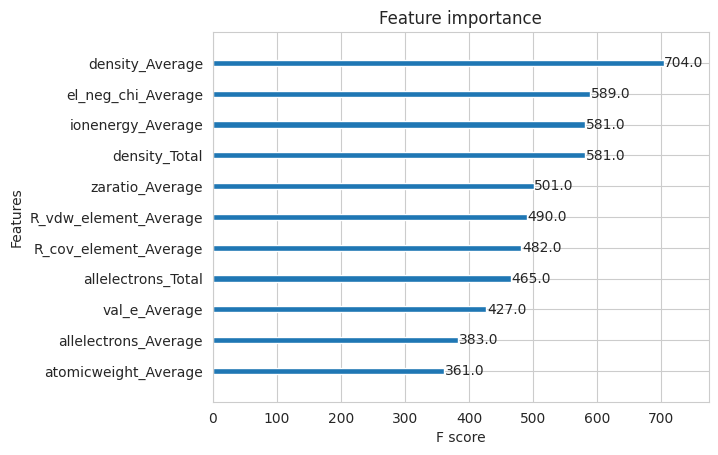

In [28]:
# plot feature importance
from matplotlib import pyplot as plt
xgb.plot_importance(model)
plt.show()